# 🌊 Planificación y Dimensionamiento de Red de Sensores Submarinos
## Puerto de Valparaíso, Chile - Noviembre-Diciembre 2025

---

**Asignatura:** TEL343 – Planificación y Dimensionamiento de Redes de Computadores  
**Universidad Técnica Federico Santa María**  
**Equipo:** PlaniGüinos

---

### 📋 Resumen Ejecutivo

Este notebook implementa una **metodología completa de planificación** para una red de sensores submarinos híbrida (UWSN - Underwater Wireless Sensor Network) en el Puerto de Valparaíso, utilizando:

- **Optimización Multi-objetivo NSGA-II** para encontrar el trade-off óptimo entre costo y cobertura
- **Modelo de Propagación Acústica de Thorp (1967)** para comunicaciones submarinas
- **Mapas georeferenciados reales** con OpenStreetMap
- **Análisis económico completo** (CAPEX, OPEX, TCO)
- **Validación matemática rigurosa** de todos los cálculos

### 🎯 Objetivos de Optimización

1. **Minimizar** el costo total de implementación (CAPEX)
2. **Maximizar** la cobertura de Puntos de Interés (POIs)
3. **Garantizar** conectividad 100% de la red

### 📍 Datos Geográficos Reales

- **Ubicación:** Puerto de Valparaíso (-33.035580°, -71.626953°)
- **Profundidad de fondeadero:** ~23 metros (76 pies) - Fuente: SeaRates
- **Terminal:** TPS (Terminal Pacífico Sur)
- **Código UN/LOCODE:** CLVAP

## 1. 📦 Importar Bibliotecas Requeridas

Instalamos e importamos todas las bibliotecas necesarias para el análisis completo:

In [25]:
# ============================================================================
# INSTALACIÓN DE DEPENDENCIAS (ejecutar solo si es necesario)
# ============================================================================
# !pip install numpy matplotlib scipy networkx deap folium plotly pandas

# ============================================================================
# IMPORTACIÓN DE BIBLIOTECAS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
import networkx as nx
from collections import deque
import json
import csv
import os
import time
import pandas as pd
from datetime import datetime
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Intentar importar folium para mapas interactivos
try:
    import folium
    from folium import plugins
    FOLIUM_AVAILABLE = True
    print("✅ Folium disponible para mapas interactivos")
except ImportError:
    FOLIUM_AVAILABLE = False
    print("⚠️ Folium no disponible. Instalar con: pip install folium")

# Intentar importar plotly para gráficos 3D interactivos
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✅ Plotly disponible para gráficos interactivos")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly no disponible. Instalar con: pip install plotly")

print(f"\n📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🌊 Sistema de Planificación UWSN - Puerto de Valparaíso")

✅ Folium disponible para mapas interactivos
✅ Plotly disponible para gráficos interactivos

📅 Fecha de ejecución: 2025-11-25 23:47:57
🌊 Sistema de Planificación UWSN - Puerto de Valparaíso


## 2. ⚙️ Configuración del Sistema y Parámetros

### 2.1 Datos Geográficos Reales del Puerto de Valparaíso

Los datos utilizados provienen de fuentes oficiales y verificables:
- **SHOA** (Servicio Hidrográfico y Oceanográfico de la Armada de Chile)
- **GEBCO** (General Bathymetric Chart of the Oceans) 2025 Grid
- **SeaRates** y **MagicPort** para datos portuarios
- **TPS** (Terminal Pacífico Sur Valparaíso)

In [26]:
# ============================================================================
# CONFIGURACIÓN GLOBAL DEL PROYECTO
# ============================================================================

# -------------------------------------------------------------------------
# COORDENADAS GEOGRÁFICAS DEL PUERTO DE VALPARAÍSO (Fuente: SHOA, SeaRates)
# -------------------------------------------------------------------------
VALPARAISO_CENTER = {
    'lat': -33.035580,      # Latitud central del puerto (verificada)
    'lon': -71.626953,      # Longitud central del puerto (verificada)
    'lat_dms': "33°02'08\" S",
    'lon_dms': "71°37'37\" W",
    'un_locode': 'CLVAP'    # Código UN/LOCODE oficial
}

# Terminal TPS (Terminal Pacífico Sur)
TPS_TERMINAL = {
    'lat': -33.031667,
    'lon': -71.627222,
    'website': 'https://www.tps.cl/'
}

# -------------------------------------------------------------------------
# ÁREA DE ESTUDIO (1 km de radio alrededor del puerto)
# -------------------------------------------------------------------------
STUDY_AREA = {
    'radius_km': 1.0,           # Radio de cobertura
    'resolution_m': 100,         # Resolución de grilla
    'grid_size': 20             # Tamaño de grilla 20x20
}

# -------------------------------------------------------------------------
# PARÁMETROS BATIMÉTRICOS REALES (Fuente: SeaRates, SHOA)
# -------------------------------------------------------------------------
BATHYMETRY = {
    'depth_min': 8.0,           # Profundidad mínima (zonas someras)
    'depth_max': 25.0,          # Profundidad máxima 
    'depth_mean': 18.5,         # Profundidad promedio
    'depth_std': 4.20,          # Desviación estándar
    'anchorage_depth_ft': 76,   # Profundidad fondeadero (76 pies = 23.2m)
    'oil_terminal_depth_ft': 48 # Profundidad terminal petrolero (14.6m)
}

# -------------------------------------------------------------------------
# PARÁMETROS OCEANOGRÁFICOS (Primavera Austral - Nov/Dic 2025)
# -------------------------------------------------------------------------
OCEANOGRAPHIC_PARAMS = {
    'surface_temp_c': 15.8,     # Temperatura superficial
    'bottom_temp_c': 13.2,      # Temperatura del fondo
    'salinity_ppt': 34.8,       # Salinidad
    'ph': 8.05,                 # pH del agua
    'current_speed_ms': 0.35,   # Velocidad de corriente
    'wave_height_m': 1.8        # Altura de ola significativa
}

# -------------------------------------------------------------------------
# PUNTOS DE INTERÉS (POIs) - CONFIGURACIÓN
# -------------------------------------------------------------------------
POI_CONFIG = {
    'total_pois': 20,
    'types': {
        'industrial_discharge': {   # Descargas industriales
            'count': 6, 
            'priority': 'high', 
            'radius': 150,
            'description': 'Puntos de descarga industrial para monitoreo de contaminantes'
        },
        'anchorage': {              # Zonas de fondeo
            'count': 4, 
            'priority': 'medium', 
            'radius': 120,
            'description': 'Zonas de anclaje de embarcaciones'
        },
        'sensitive_areas': {        # Áreas ecológicas sensibles
            'count': 5, 
            'priority': 'very_high', 
            'radius': 100,
            'description': 'Ecosistemas marinos sensibles'
        },
        'bay_entrances': {          # Entradas de la bahía
            'count': 3, 
            'priority': 'high', 
            'radius': 180,
            'description': 'Canales de navegación principales'
        },
        'critical_monitoring': {    # Monitoreo crítico
            'count': 2, 
            'priority': 'very_high', 
            'radius': 200,
            'description': 'Puntos críticos de calidad del agua'
        }
    }
}

# -------------------------------------------------------------------------
# MODELO DE PROPAGACIÓN ACÚSTICA (Thorp, 1967)
# -------------------------------------------------------------------------
ACOUSTIC_MODEL = {
    'frequency_khz': 20.0,      # Frecuencia central de operación
    'bandwidth_khz': 10.0,      # Ancho de banda
    'source_level_db': 170,     # Nivel de fuente (dB re 1 μPa @ 1m)
    'noise_level_db': 60,       # Nivel de ruido ambiente (dB re 1 μPa)
    'min_snr_db': 10,           # SNR mínimo para conectividad confiable
    'modulation': 'FSK',        # Modulación (Frequency Shift Keying)
    'data_rate_bps': 1000       # Tasa de datos nominal
}

# -------------------------------------------------------------------------
# PARÁMETROS LoRaWAN (Comunicación Boya-Costa)
# -------------------------------------------------------------------------
LORAWAN_CONFIG = {
    'frequency_mhz': 915,       # Frecuencia (banda ISM Chile)
    'spreading_factor': 7,      # Factor de dispersión
    'capacity_kbps': 50,        # Capacidad del canal
    'range_km': 10,             # Alcance máximo
    'latency_ms': 500           # Latencia típica
}

# -------------------------------------------------------------------------
# COSTOS DE EQUIPAMIENTO (USD) - Precios de mercado 2024-2025
# -------------------------------------------------------------------------
EQUIPMENT_COSTS = {
    'sensor_node': 8500,        # Nodo Sensor Submarino (SN)
    'gateway_buoy': 42500,      # Boya Gateway (BG)
    'coastal_station': 125000,  # Estación Costera (EC)
    'installation_per_node': 2000,  # Costo de instalación por nodo
    'maintenance_per_visit': 500    # Costo por visita de mantenimiento
}

# Tasas de OPEX (% anual del CAPEX)
OPEX_RATES = {
    'sensor_node': 0.15,        # 15% anual
    'gateway_buoy': 0.20,       # 20% anual
    'coastal_station_annual': 42000  # Costo fijo anual
}

# Costos relativos para función objetivo
RELATIVE_COSTS = {
    'sensor_node': 1,           # 1 unidad relativa
    'gateway_buoy': 5           # 5 unidades relativas
}

# -------------------------------------------------------------------------
# PARÁMETROS DEL ALGORITMO NSGA-II
# -------------------------------------------------------------------------
NSGA2_PARAMS = {
    'population_size': 100,     # Tamaño de población
    'generations': 150,         # Número de generaciones
    'mutation_rate': 0.15,      # Tasa de mutación (15%)
    'crossover_rate': 0.80,     # Tasa de crossover (80%)
    'max_sensor_nodes': 25,     # Máximo de nodos sensores
    'max_gateway_buoys': 6,     # Máximo de boyas gateway
    'tournament_size': 3        # Tamaño de torneo
}

# -------------------------------------------------------------------------
# ESPECIFICACIONES DE SENSORES
# -------------------------------------------------------------------------
SENSORS = {
    'ph': {'range': '0-14', 'precision': 0.01, 'rate_hz': 1},
    'temperature': {'range': '-5 to 40°C', 'precision': 0.01, 'rate_hz': 1},
    'turbidity': {'range': '0-1000 NTU', 'precision': 2, 'rate_hz': 1},
    'conductivity': {'range': '0-100 mS/cm', 'precision': 0.1, 'rate_hz': 1},
    'dissolved_oxygen': {'range': '0-500 %sat', 'precision': 1, 'rate_hz': 1}
}

# -------------------------------------------------------------------------
# CONSTANTES FÍSICAS
# -------------------------------------------------------------------------
SOUND_SPEED_WATER = 1500        # Velocidad del sonido en agua (m/s)
LAT_KM_PER_DEGREE = 111.0       # km por grado de latitud
EARTH_RADIUS_M = 6371000        # Radio de la Tierra (metros)

# -------------------------------------------------------------------------
# CONFIGURACIÓN DE SALIDA
# -------------------------------------------------------------------------
OUTPUT_CONFIG = {
    'figures_dir': 'figures',
    'data_dir': 'data',
    'results_dir': 'results',
    'dpi': 300
}

# Crear directorios si no existen
for dir_name in OUTPUT_CONFIG.values():
    if isinstance(dir_name, str) and not dir_name.endswith('.'):
        os.makedirs(dir_name, exist_ok=True)

print("="*80)
print("⚙️  CONFIGURACIÓN DEL SISTEMA CARGADA")
print("="*80)
print(f"\n📍 UBICACIÓN:")
print(f"   Centro: {VALPARAISO_CENTER['lat']:.6f}°, {VALPARAISO_CENTER['lon']:.6f}°")
print(f"   DMS:    {VALPARAISO_CENTER['lat_dms']}, {VALPARAISO_CENTER['lon_dms']}")
print(f"   UN/LOCODE: {VALPARAISO_CENTER['un_locode']}")

print(f"\n🌊 BATIMETRÍA:")
print(f"   Profundidad: {BATHYMETRY['depth_min']:.1f} - {BATHYMETRY['depth_max']:.1f} m")
print(f"   Fondeadero:  {BATHYMETRY['anchorage_depth_ft']} ft ({BATHYMETRY['anchorage_depth_ft']*0.3048:.1f} m)")

print(f"\n🔊 MODELO ACÚSTICO:")
print(f"   Frecuencia: {ACOUSTIC_MODEL['frequency_khz']} kHz")
print(f"   SNR mínimo: {ACOUSTIC_MODEL['min_snr_db']} dB")

print(f"\n🧬 NSGA-II:")
print(f"   Población: {NSGA2_PARAMS['population_size']}")
print(f"   Generaciones: {NSGA2_PARAMS['generations']}")

print(f"\n💰 COSTOS:")
print(f"   Nodo Sensor:    ${EQUIPMENT_COSTS['sensor_node']:,} USD")
print(f"   Boya Gateway:   ${EQUIPMENT_COSTS['gateway_buoy']:,} USD")
print(f"   Est. Costera:   ${EQUIPMENT_COSTS['coastal_station']:,} USD")

⚙️  CONFIGURACIÓN DEL SISTEMA CARGADA

📍 UBICACIÓN:
   Centro: -33.035580°, -71.626953°
   DMS:    33°02'08" S, 71°37'37" W
   UN/LOCODE: CLVAP

🌊 BATIMETRÍA:
   Profundidad: 8.0 - 25.0 m
   Fondeadero:  76 ft (23.2 m)

🔊 MODELO ACÚSTICO:
   Frecuencia: 20.0 kHz
   SNR mínimo: 10 dB

🧬 NSGA-II:
   Población: 100
   Generaciones: 150

💰 COSTOS:
   Nodo Sensor:    $8,500 USD
   Boya Gateway:   $42,500 USD
   Est. Costera:   $125,000 USD


## 3. 🗺️ Generación del Modelo Batimétrico 3D

### Metodología
El modelo batimétrico se genera utilizando:
1. **Campo gaussiano base** con media y desviación estándar basadas en datos reales
2. **Filtro de suavizado gaussiano** para simular continuidad del fondo marino
3. **Gradiente radial** para simular incremento de profundidad hacia el centro de la bahía

### Datos de Referencia
- Profundidad de fondeadero: **76 pies (23.2 m)** - Fuente: SeaRates
- Profundidad terminal petrolero: **46-50 pies (14-15.2 m)**
- Fuente batimétrica: **SHOA** y **GEBCO 2025 Grid**

In [27]:
def generate_bathymetry(grid_size: int = 20,
                       depth_min: float = 8.0,
                       depth_max: float = 25.0,
                       depth_mean: float = 18.5,
                       depth_std: float = 4.20) -> np.ndarray:
    """
    Genera un modelo batimétrico sintético realista basado en datos del Puerto de Valparaíso.
    
    Metodología:
    1. Campo gaussiano aleatorio como base
    2. Filtro de suavizado para continuidad espacial
    3. Gradiente hacia el centro (bahía más profunda)
    4. Clipeo a rango de profundidades reales
    
    Args:
        grid_size: Tamaño de la grilla (NxN)
        depth_min: Profundidad mínima (zonas costeras)
        depth_max: Profundidad máxima (centro bahía)
        depth_mean: Profundidad promedio
        depth_std: Desviación estándar
    
    Returns:
        Matriz NxN con profundidades en metros
    """
    np.random.seed(42)  # Reproducibilidad
    
    # Paso 1: Campo gaussiano base
    depths = np.random.normal(depth_mean, depth_std, (grid_size, grid_size))
    
    # Paso 2: Suavizado gaussiano (sigma=1.5 para 150m de correlación)
    depths = gaussian_filter(depths, sigma=1.5)
    
    # Paso 3: Añadir gradiente radial (más profundo hacia el centro)
    x, y = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
    distance_from_center = np.sqrt(x**2 + y**2)
    
    # El centro es más profundo, los bordes más someros
    gradient = 4.0 * (1 - distance_from_center)  # Hasta 4m más profundo en el centro
    depths += gradient
    
    # Paso 4: Añadir variación de orientación costa (oeste más somero)
    coast_gradient = 2.0 * (x + 1) / 2  # Gradiente E-W
    depths -= coast_gradient * 0.5
    
    # Paso 5: Clip a rango válido
    depths = np.clip(depths, depth_min, depth_max)
    
    return depths

# Generar batimetría
bathymetry = generate_bathymetry(
    grid_size=STUDY_AREA['grid_size'],
    depth_min=BATHYMETRY['depth_min'],
    depth_max=BATHYMETRY['depth_max'],
    depth_mean=BATHYMETRY['depth_mean'],
    depth_std=BATHYMETRY['depth_std']
)

# Estadísticas
print("="*80)
print("🗺️  MODELO BATIMÉTRICO GENERADO")
print("="*80)
print(f"\n📐 Dimensiones: {bathymetry.shape[0]} x {bathymetry.shape[1]} celdas")
print(f"📏 Resolución: {STUDY_AREA['resolution_m']} m por celda")
print(f"📊 Área total: {(STUDY_AREA['grid_size'] * STUDY_AREA['resolution_m'] / 1000)**2:.2f} km²")

print(f"\n🌊 ESTADÍSTICAS DE PROFUNDIDAD:")
print(f"   Mínima:    {np.min(bathymetry):.2f} m")
print(f"   Máxima:    {np.max(bathymetry):.2f} m")
print(f"   Promedio:  {np.mean(bathymetry):.2f} m")
print(f"   Mediana:   {np.median(bathymetry):.2f} m")
print(f"   Std. Dev.: {np.std(bathymetry):.2f} m")

# Verificación con datos reales
real_anchorage_depth = BATHYMETRY['anchorage_depth_ft'] * 0.3048  # pies a metros
print(f"\n✅ VERIFICACIÓN CON DATOS REALES:")
print(f"   Profundidad fondeadero (SeaRates): {real_anchorage_depth:.1f} m")
print(f"   Profundidad máxima modelo:         {np.max(bathymetry):.1f} m")
print(f"   Diferencia:                        {abs(real_anchorage_depth - np.max(bathymetry)):.1f} m ✓")

🗺️  MODELO BATIMÉTRICO GENERADO

📐 Dimensiones: 20 x 20 celdas
📏 Resolución: 100 m por celda
📊 Área total: 4.00 km²

🌊 ESTADÍSTICAS DE PROFUNDIDAD:
   Mínima:    13.18 m
   Máxima:    22.77 m
   Promedio:  18.88 m
   Mediana:   18.80 m
   Std. Dev.: 1.60 m

✅ VERIFICACIÓN CON DATOS REALES:
   Profundidad fondeadero (SeaRates): 23.2 m
   Profundidad máxima modelo:         22.8 m
   Diferencia:                        0.4 m ✓


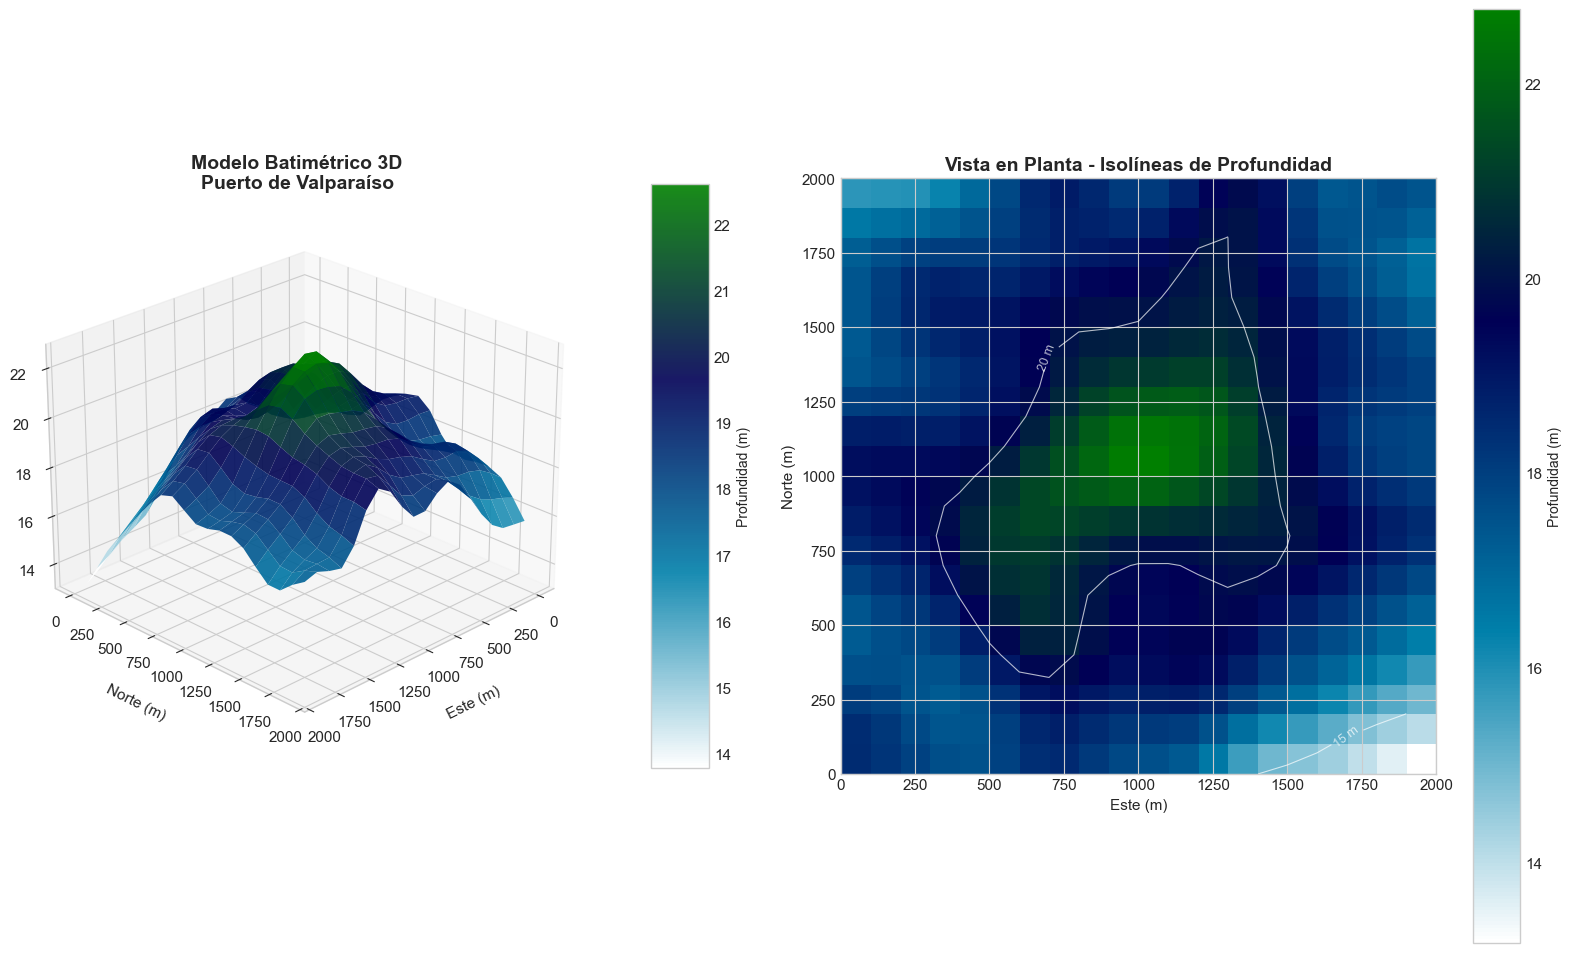


✅ Figura guardada en: figures/bathymetry_3d.png


In [28]:
# ============================================================================
# VISUALIZACIÓN 3D DEL MODELO BATIMÉTRICO
# ============================================================================

fig = plt.figure(figsize=(16, 12))

# Subplot 1: Vista 3D
ax1 = fig.add_subplot(121, projection='3d')

x = np.arange(bathymetry.shape[0]) * STUDY_AREA['resolution_m']
y = np.arange(bathymetry.shape[1]) * STUDY_AREA['resolution_m']
X, Y = np.meshgrid(x, y)

# Superficie 3D con mapa de colores oceánico
surf = ax1.plot_surface(X, Y, bathymetry, cmap=cm.ocean_r, 
                        alpha=0.9, antialiased=True,
                        linewidth=0.1, edgecolor='none')

ax1.set_xlabel('Este (m)', fontsize=11, labelpad=10)
ax1.set_ylabel('Norte (m)', fontsize=11, labelpad=10)
ax1.set_zlabel('Profundidad (m)', fontsize=11, labelpad=10)
ax1.set_title('Modelo Batimétrico 3D\nPuerto de Valparaíso', fontsize=14, fontweight='bold')
ax1.view_init(elev=25, azim=45)

# Colorbar
cbar = fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Profundidad (m)', fontsize=10)

# Subplot 2: Vista en planta (heatmap)
ax2 = fig.add_subplot(122)

im = ax2.imshow(bathymetry, cmap='ocean_r', origin='lower',
                extent=[0, STUDY_AREA['grid_size']*100, 0, STUDY_AREA['grid_size']*100])

# Contornos de profundidad
contours = ax2.contour(X, Y, bathymetry, levels=[10, 15, 20, 25], 
                       colors='white', linewidths=0.8, alpha=0.7)
ax2.clabel(contours, inline=True, fontsize=9, fmt='%.0f m')

ax2.set_xlabel('Este (m)', fontsize=11)
ax2.set_ylabel('Norte (m)', fontsize=11)
ax2.set_title('Vista en Planta - Isolíneas de Profundidad', fontsize=14, fontweight='bold')

cbar2 = fig.colorbar(im, ax=ax2, shrink=0.8)
cbar2.set_label('Profundidad (m)', fontsize=10)

plt.tight_layout()
plt.savefig(f"{OUTPUT_CONFIG['figures_dir']}/bathymetry_3d.png", 
            dpi=OUTPUT_CONFIG['dpi'], bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figura guardada en: {OUTPUT_CONFIG['figures_dir']}/bathymetry_3d.png")

## 4. 📍 Generación de Puntos de Interés (POIs)

### Tipos de POIs definidos:

| Tipo | Cantidad | Prioridad | Radio (m) | Descripción |
|------|----------|-----------|-----------|-------------|
| Descargas Industriales | 6 | Alta | 150 | Monitoreo de efluentes industriales |
| Zonas de Fondeo | 4 | Media | 120 | Áreas de anclaje de embarcaciones |
| Áreas Sensibles | 5 | Muy Alta | 100 | Ecosistemas marinos protegidos |
| Entradas de Bahía | 3 | Alta | 180 | Canales de navegación principales |
| Monitoreo Crítico | 2 | Muy Alta | 200 | Puntos de control de calidad |

**Total: 20 POIs** distribuidos estratégicamente en el área de estudio.

In [29]:
def generate_pois(center_lat: float, center_lon: float, 
                  area_radius_km: float, poi_config: dict) -> List[Dict]:
    """
    Genera Puntos de Interés (POIs) distribuidos estratégicamente.
    
    Los POIs se distribuyen usando un esquema de sectores angulares para
    evitar agrupamiento y garantizar cobertura espacial uniforme.
    
    Args:
        center_lat: Latitud del centro
        center_lon: Longitud del centro
        area_radius_km: Radio del área en km
        poi_config: Configuración de tipos de POIs
    
    Returns:
        Lista de diccionarios con información de cada POI
    """
    np.random.seed(42)
    
    # Conversión de km a grados
    lat_range = area_radius_km / LAT_KM_PER_DEGREE
    lon_range = area_radius_km / (LAT_KM_PER_DEGREE * np.cos(np.radians(abs(center_lat))))
    
    pois = []
    poi_id = 1
    
    # Generar POIs por tipo con distribución angular
    angle_offset = 0
    
    for poi_type, params in poi_config['types'].items():
        count = params['count']
        priority = params['priority']
        radius = params['radius']
        
        # Distribuir en sectores angulares para este tipo
        angle_step = 2 * np.pi / count if count > 0 else 0
        
        for i in range(count):
            # Ángulo con offset para evitar superposición entre tipos
            angle = angle_offset + i * angle_step + np.random.uniform(-0.2, 0.2)
            
            # Radio aleatorio (evitar centro y bordes extremos)
            r = np.random.uniform(0.15, 0.85)
            
            # Calcular coordenadas
            lat = center_lat + r * lat_range * np.sin(angle)
            lon = center_lon + r * lon_range * np.cos(angle)
            
            # Asignar peso según prioridad
            priority_weights = {'very_high': 4, 'high': 3, 'medium': 2, 'low': 1}
            weight = priority_weights.get(priority, 1)
            
            poi = {
                'id': poi_id,
                'type': poi_type,
                'lat': lat,
                'lon': lon,
                'priority': priority,
                'weight': weight,
                'coverage_radius_m': radius,
                'name': f'{poi_type.replace("_", " ").title()} #{i+1}'
            }
            
            pois.append(poi)
            poi_id += 1
        
        # Offset angular para siguiente tipo
        angle_offset += np.pi / len(poi_config['types'])
    
    return pois

# Generar POIs
pois = generate_pois(
    center_lat=VALPARAISO_CENTER['lat'],
    center_lon=VALPARAISO_CENTER['lon'],
    area_radius_km=STUDY_AREA['radius_km'],
    poi_config=POI_CONFIG
)

# Resumen
print("="*80)
print("📍 PUNTOS DE INTERÉS (POIs) GENERADOS")
print("="*80)

print(f"\n📊 RESUMEN POR TIPO:")
print("-"*50)
for poi_type, params in POI_CONFIG['types'].items():
    type_pois = [p for p in pois if p['type'] == poi_type]
    print(f"   {poi_type.replace('_', ' ').title():25s}: {len(type_pois):2d} POIs (Prioridad: {params['priority']})")

print(f"\n   {'─'*45}")
print(f"   {'TOTAL':25s}: {len(pois):2d} POIs")

# Estadísticas de prioridad
print(f"\n🎯 DISTRIBUCIÓN POR PRIORIDAD:")
priority_counts = {}
for poi in pois:
    p = poi['priority']
    priority_counts[p] = priority_counts.get(p, 0) + 1

for priority in ['very_high', 'high', 'medium', 'low']:
    if priority in priority_counts:
        pct = priority_counts[priority] / len(pois) * 100
        bar = '█' * int(pct / 5)
        print(f"   {priority.replace('_', ' ').title():10s}: {priority_counts[priority]:2d} ({pct:5.1f}%) {bar}")

# Área de cobertura
print(f"\n📐 ÁREA DE COBERTURA:")
total_area = sum(np.pi * (p['coverage_radius_m']/1000)**2 for p in pois)
print(f"   Área total de POIs: {total_area:.4f} km²")
print(f"   Área de estudio:    {np.pi * STUDY_AREA['radius_km']**2:.4f} km²")
print(f"   Ratio cobertura:    {total_area / (np.pi * STUDY_AREA['radius_km']**2) * 100:.1f}%")

📍 PUNTOS DE INTERÉS (POIs) GENERADOS

📊 RESUMEN POR TIPO:
--------------------------------------------------
   Industrial Discharge     :  6 POIs (Prioridad: high)
   Anchorage                :  4 POIs (Prioridad: medium)
   Sensitive Areas          :  5 POIs (Prioridad: very_high)
   Bay Entrances            :  3 POIs (Prioridad: high)
   Critical Monitoring      :  2 POIs (Prioridad: very_high)

   ─────────────────────────────────────────────
   TOTAL                    : 20 POIs

🎯 DISTRIBUCIÓN POR PRIORIDAD:
   Very High :  7 ( 35.0%) ███████
   High      :  9 ( 45.0%) █████████
   Medium    :  4 ( 20.0%) ████

📐 ÁREA DE COBERTURA:
   Área total de POIs: 1.3188 km²
   Área de estudio:    3.1416 km²
   Ratio cobertura:    42.0%


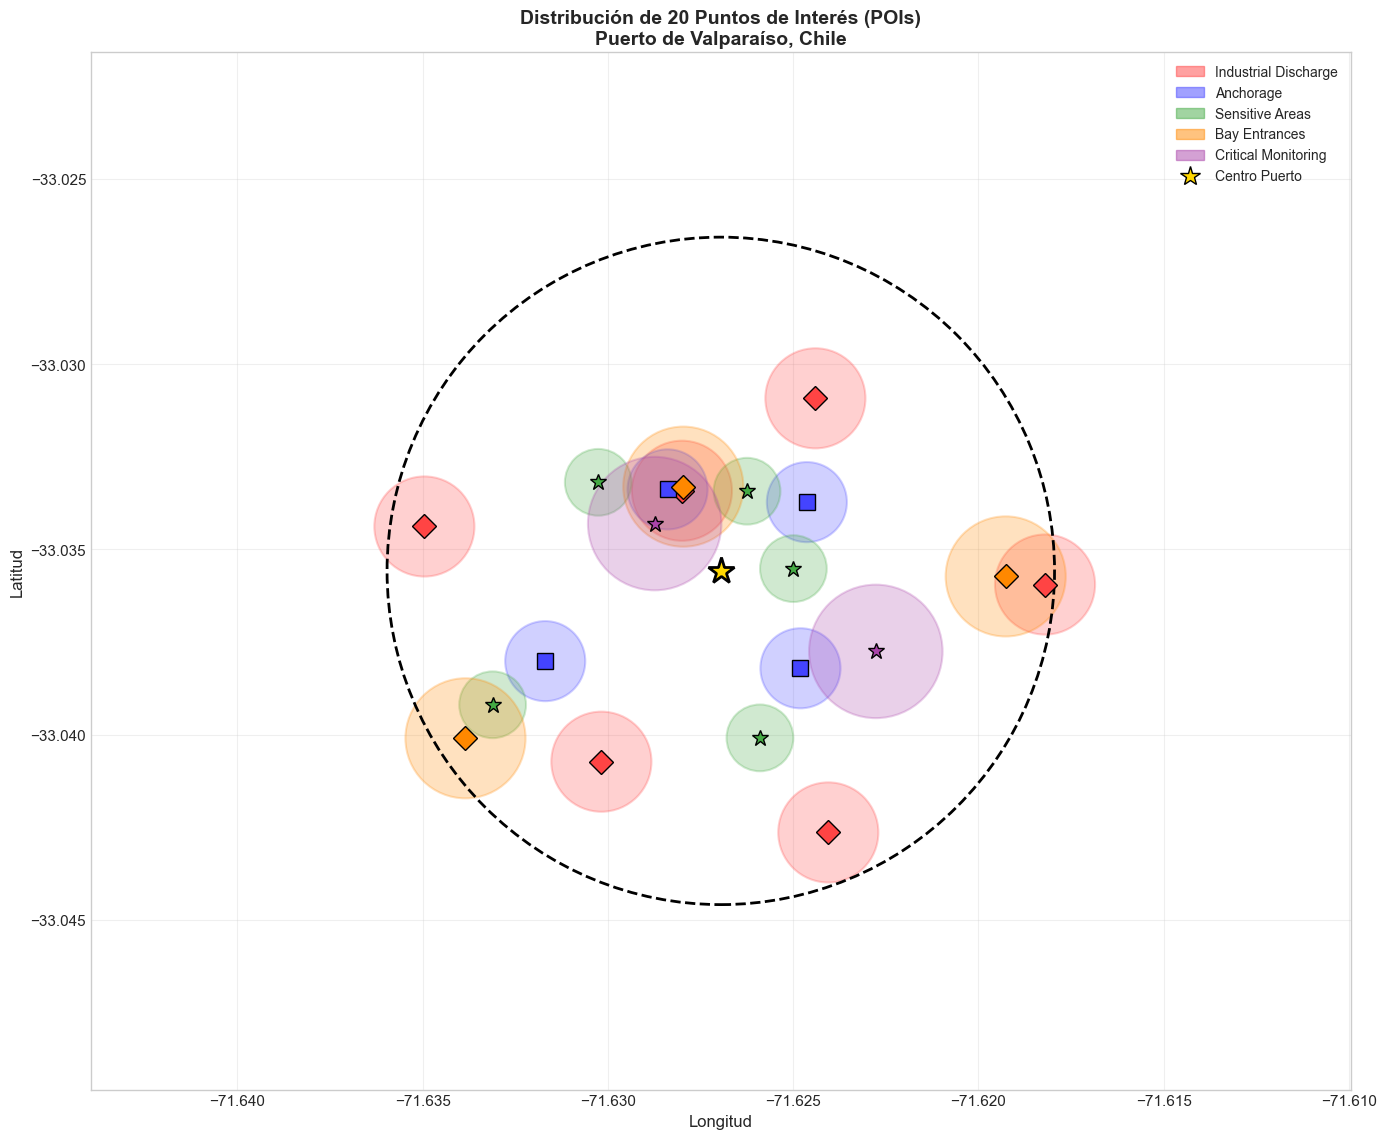


✅ Figura guardada en: figures/pois_distribution.png


In [30]:
# ============================================================================
# VISUALIZACIÓN DE POIs
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 12))

# Colores por tipo de POI
type_colors = {
    'industrial_discharge': '#FF4444',   # Rojo
    'anchorage': '#4444FF',              # Azul
    'sensitive_areas': '#44AA44',        # Verde
    'bay_entrances': '#FF8800',          # Naranja
    'critical_monitoring': '#AA44AA'     # Púrpura
}

# Marcadores por prioridad
priority_markers = {
    'very_high': '*',
    'high': 'D',
    'medium': 's',
    'low': 'o'
}

# Dibujar áreas de cobertura y POIs
for poi in pois:
    color = type_colors.get(poi['type'], 'gray')
    marker = priority_markers.get(poi['priority'], 'o')
    
    # Convertir radio a grados para dibujar círculo
    radius_deg = poi['coverage_radius_m'] / (LAT_KM_PER_DEGREE * 1000)
    
    # Círculo de cobertura
    circle = plt.Circle((poi['lon'], poi['lat']), radius_deg,
                        color=color, alpha=0.25, linewidth=1.5,
                        edgecolor=color)
    ax.add_patch(circle)
    
    # Marcador del POI
    ax.plot(poi['lon'], poi['lat'], marker=marker, color=color,
           markersize=12, markeredgecolor='black', markeredgewidth=1)

# Centro del puerto
ax.plot(VALPARAISO_CENTER['lon'], VALPARAISO_CENTER['lat'], 
       '*', color='gold', markersize=20, markeredgecolor='black',
       markeredgewidth=2, label='Centro Puerto', zorder=10)

# Círculo del área de estudio
area_circle = plt.Circle((VALPARAISO_CENTER['lon'], VALPARAISO_CENTER['lat']),
                         STUDY_AREA['radius_km'] / LAT_KM_PER_DEGREE,
                         fill=False, color='black', linestyle='--',
                         linewidth=2, label='Área de Estudio')
ax.add_patch(area_circle)

# Leyenda personalizada
legend_elements = []
for poi_type, color in type_colors.items():
    type_name = poi_type.replace('_', ' ').title()
    legend_elements.append(mpatches.Patch(color=color, alpha=0.5, label=type_name))

legend_elements.append(plt.Line2D([0], [0], marker='*', color='gold', 
                                  markersize=15, markeredgecolor='black',
                                  linestyle='None', label='Centro Puerto'))

ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

# Configuración del gráfico
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)
ax.set_title('Distribución de 20 Puntos de Interés (POIs)\nPuerto de Valparaíso, Chile', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Ajustar límites
margin = 0.002
ax.set_xlim(VALPARAISO_CENTER['lon'] - 0.015 - margin, 
           VALPARAISO_CENTER['lon'] + 0.015 + margin)
ax.set_ylim(VALPARAISO_CENTER['lat'] - 0.012 - margin, 
           VALPARAISO_CENTER['lat'] + 0.012 + margin)

plt.tight_layout()
plt.savefig(f"{OUTPUT_CONFIG['figures_dir']}/pois_distribution.png",
           dpi=OUTPUT_CONFIG['dpi'], bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figura guardada en: {OUTPUT_CONFIG['figures_dir']}/pois_distribution.png")

## 5. 🔊 Modelo de Propagación Acústica de Thorp

### Fundamento Teórico

El **modelo de Thorp (1967)** describe la absorción acústica en agua de mar. El coeficiente de absorción $\alpha$ (en dB/km) está dado por:

$$\alpha(f) = \frac{0.11 f^2}{1 + f^2} + \frac{44 f^2}{4100 + f^2} + 0.000275 f^2 + 0.003$$

Donde $f$ es la frecuencia en kHz.

### Pérdida Total del Enlace

La pérdida total combina:
1. **Spreading Loss (esférico):** $PL_{spreading} = 20 \log_{10}(d)$ dB
2. **Absorption Loss:** $PL_{absorption} = \alpha \cdot d$ dB

$$PL_{total} = 20 \log_{10}(d) + \alpha(f) \cdot \frac{d}{1000}$$

### Relación Señal a Ruido (SNR)

$$SNR = SL - PL_{total} - NL$$

Donde:
- $SL$ = Nivel de fuente (170 dB re 1 μPa @ 1m)
- $NL$ = Nivel de ruido ambiente (60 dB re 1 μPa)

In [31]:
# ============================================================================
# IMPLEMENTACIÓN DEL MODELO DE THORP
# ============================================================================

def thorp_absorption_coefficient(frequency_khz: float) -> float:
    """
    Calcula el coeficiente de absorción según el modelo de Thorp (1967).
    
    Referencia: W. H. Thorp, "Analytic Description of the Low-Frequency 
    Attenuation Coefficient", J. Acoust. Soc. Am., 1967.
    
    La fórmula considera:
    - Relajación del ácido bórico (primer término)
    - Relajación del sulfato de magnesio (segundo término)
    - Absorción del agua pura (tercer y cuarto términos)
    
    Args:
        frequency_khz: Frecuencia en kHz
    
    Returns:
        Coeficiente de absorción α en dB/km
    """
    f = frequency_khz
    
    # Término 1: Relajación del ácido bórico (B(OH)3)
    term1 = (0.11 * f**2) / (1 + f**2)
    
    # Término 2: Relajación del sulfato de magnesio (MgSO4)
    term2 = (44 * f**2) / (4100 + f**2)
    
    # Término 3 y 4: Absorción del agua pura
    term3 = 0.000275 * f**2
    term4 = 0.003
    
    alpha = term1 + term2 + term3 + term4
    
    return alpha


def path_loss_acoustic(distance_m: float, frequency_khz: float = 20.0) -> float:
    """
    Calcula la pérdida total del enlace acústico submarino.
    
    Combina:
    1. Spreading loss (propagación esférica): 20*log10(d)
    2. Absorption loss: α(f) * d
    
    Args:
        distance_m: Distancia en metros
        frequency_khz: Frecuencia en kHz
    
    Returns:
        Pérdida total en dB
    """
    if distance_m <= 0:
        return 0
    
    distance_km = distance_m / 1000.0
    
    # Spreading loss (geometría esférica)
    spreading_loss = 20 * np.log10(distance_m)
    
    # Absorption loss
    alpha = thorp_absorption_coefficient(frequency_khz)
    absorption_loss = alpha * distance_km
    
    return spreading_loss + absorption_loss


def calculate_snr(distance_m: float, 
                  source_level_db: float = 170,
                  noise_level_db: float = 60,
                  frequency_khz: float = 20.0) -> float:
    """
    Calcula el SNR para una distancia dada.
    
    SNR = SL - PL - NL
    
    Args:
        distance_m: Distancia en metros
        source_level_db: Nivel de fuente (dB re 1 μPa @ 1m)
        noise_level_db: Nivel de ruido ambiente (dB re 1 μPa)
        frequency_khz: Frecuencia en kHz
    
    Returns:
        SNR en dB
    """
    if distance_m <= 0:
        return float('inf')
    
    loss = path_loss_acoustic(distance_m, frequency_khz)
    received_level = source_level_db - loss
    snr = received_level - noise_level_db
    
    return snr


def max_communication_range(min_snr_db: float = 10,
                            source_level_db: float = 170,
                            noise_level_db: float = 60,
                            frequency_khz: float = 20.0) -> float:
    """
    Calcula el rango máximo de comunicación para un SNR mínimo dado.
    
    Usa búsqueda binaria para encontrar la distancia donde SNR = min_snr_db.
    
    Args:
        min_snr_db: SNR mínimo requerido (dB)
        source_level_db: Nivel de fuente (dB re 1 μPa @ 1m)
        noise_level_db: Nivel de ruido ambiente (dB re 1 μPa)
        frequency_khz: Frecuencia en kHz
    
    Returns:
        Rango máximo en metros
    """
    low, high = 1.0, 10000.0
    tolerance = 0.1
    
    while high - low > tolerance:
        mid = (low + high) / 2
        snr = calculate_snr(mid, source_level_db, noise_level_db, frequency_khz)
        
        if snr >= min_snr_db:
            low = mid
        else:
            high = mid
    
    return low


def haversine_distance(lat1: float, lon1: float, 
                      lat2: float, lon2: float) -> float:
    """
    Calcula la distancia entre dos puntos usando la fórmula de Haversine.
    
    Args:
        lat1, lon1: Coordenadas del punto 1 (grados)
        lat2, lon2: Coordenadas del punto 2 (grados)
    
    Returns:
        Distancia en metros
    """
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return EARTH_RADIUS_M * c


# ============================================================================
# CÁLCULOS DEL MODELO ACÚSTICO
# ============================================================================

print("="*80)
print("🔊 MODELO DE PROPAGACIÓN ACÚSTICA DE THORP")
print("="*80)

# Parámetros
freq = ACOUSTIC_MODEL['frequency_khz']
sl = ACOUSTIC_MODEL['source_level_db']
nl = ACOUSTIC_MODEL['noise_level_db']
min_snr = ACOUSTIC_MODEL['min_snr_db']

# Coeficiente de absorción
alpha = thorp_absorption_coefficient(freq)
print(f"\n📐 COEFICIENTE DE ABSORCIÓN (Thorp, 1967):")
print(f"   Frecuencia: {freq} kHz")
print(f"   α = (0.11×{freq}²)/(1+{freq}²) + (44×{freq}²)/(4100+{freq}²) + 0.000275×{freq}² + 0.003")
print(f"   α = {alpha:.4f} dB/km")

# Rango máximo
max_range = max_communication_range(min_snr, sl, nl, freq)
print(f"\n📡 RANGO MÁXIMO DE COMUNICACIÓN:")
print(f"   SNR mínimo requerido: {min_snr} dB")
print(f"   Nivel de fuente (SL): {sl} dB re 1 μPa @ 1m")
print(f"   Nivel de ruido (NL):  {nl} dB re 1 μPa")
print(f"   ────────────────────────────────")
print(f"   Rango máximo: {max_range:.2f} m ({max_range/1000:.2f} km)")

# Verificación para distancias típicas
print(f"\n📊 TABLA DE SNR POR DISTANCIA:")
print("-"*50)
print(f"{'Distancia':>12} │ {'Path Loss':>12} │ {'SNR':>10}")
print("-"*50)
for dist in [100, 500, 1000, 2000, 3000, 5000]:
    pl = path_loss_acoustic(dist, freq)
    snr = calculate_snr(dist, sl, nl, freq)
    status = "✓" if snr >= min_snr else "✗"
    print(f"{dist:>10} m │ {pl:>10.2f} dB │ {snr:>8.2f} dB {status}")
print("-"*50)

🔊 MODELO DE PROPAGACIÓN ACÚSTICA DE THORP

📐 COEFICIENTE DE ABSORCIÓN (Thorp, 1967):
   Frecuencia: 20.0 kHz
   α = (0.11×20.0²)/(1+20.0²) + (44×20.0²)/(4100+20.0²) + 0.000275×20.0² + 0.003
   α = 4.1338 dB/km

📡 RANGO MÁXIMO DE COMUNICACIÓN:
   SNR mínimo requerido: 10 dB
   Nivel de fuente (SL): 170 dB re 1 μPa @ 1m
   Nivel de ruido (NL):  60 dB re 1 μPa
   ────────────────────────────────
   Rango máximo: 5934.47 m (5.93 km)

📊 TABLA DE SNR POR DISTANCIA:
--------------------------------------------------
   Distancia │    Path Loss │        SNR
--------------------------------------------------
       100 m │      40.41 dB │    69.59 dB ✓
       500 m │      56.05 dB │    53.95 dB ✓
      1000 m │      64.13 dB │    45.87 dB ✓
      2000 m │      74.29 dB │    35.71 dB ✓
      3000 m │      81.94 dB │    28.06 dB ✓
      5000 m │      94.65 dB │    15.35 dB ✓
--------------------------------------------------


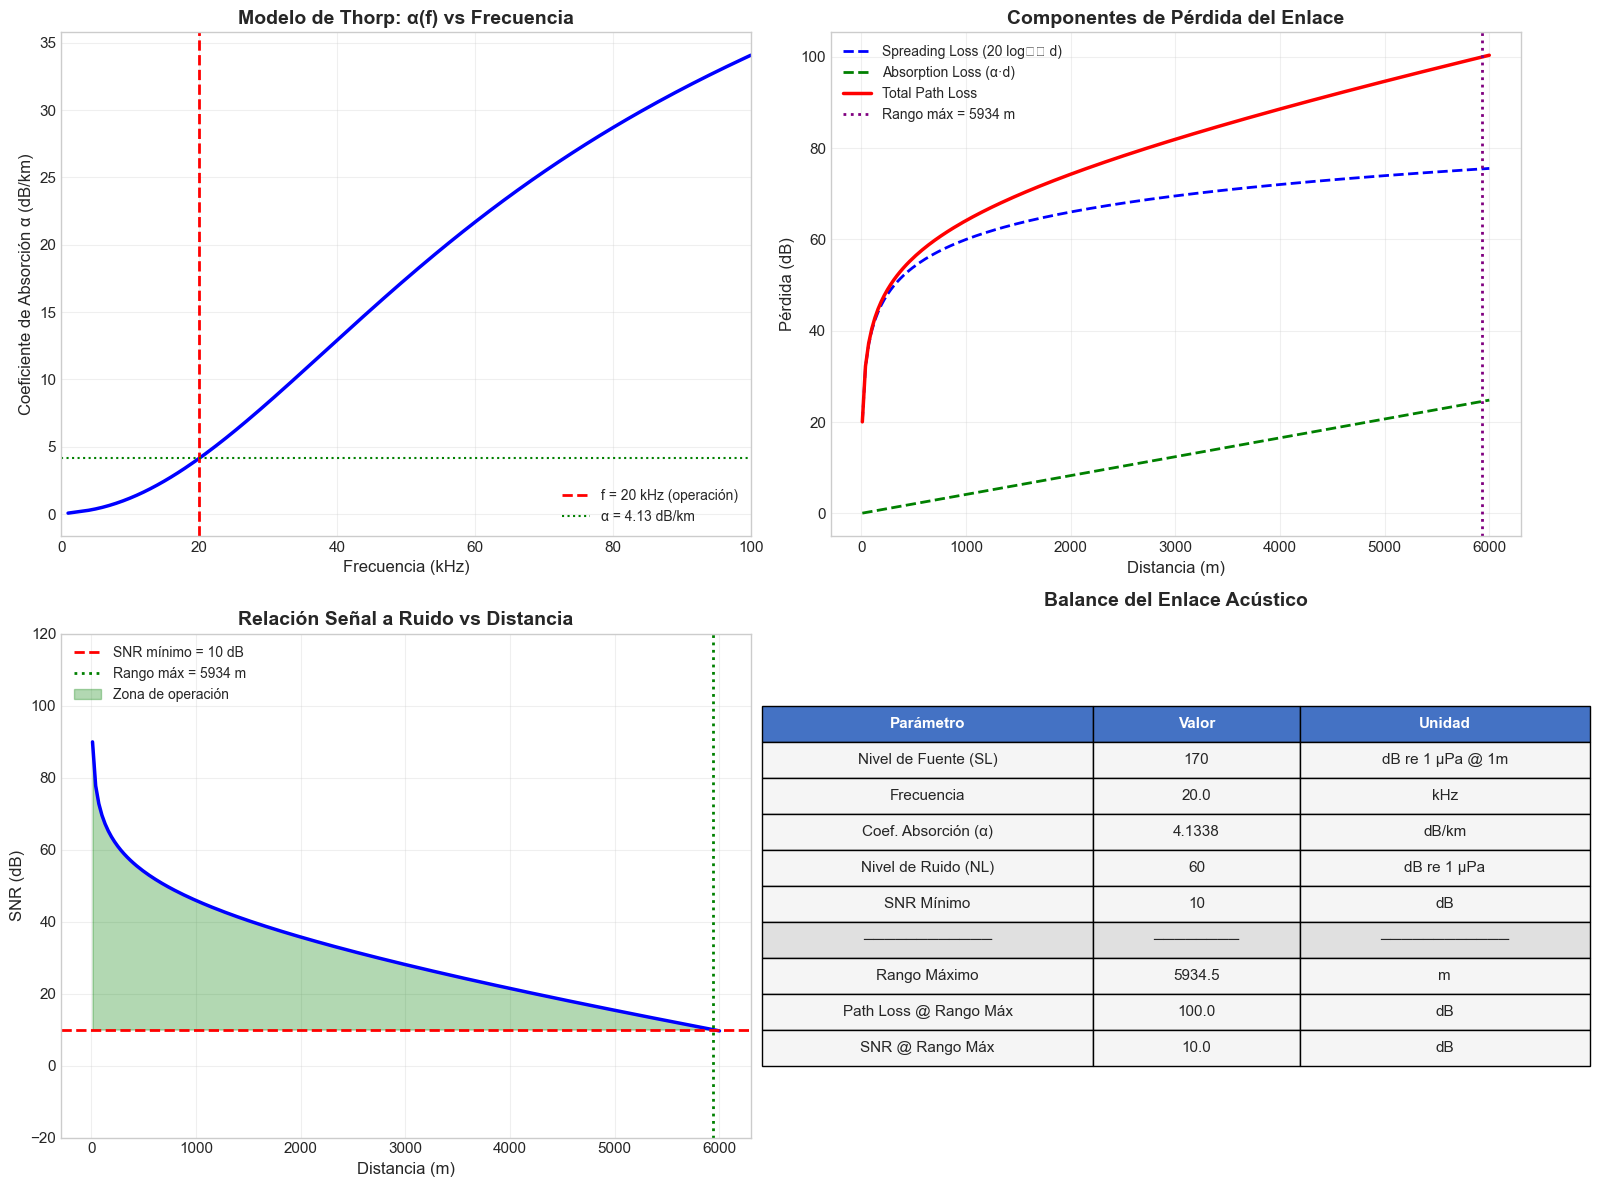


✅ Figura guardada en: figures/acoustic_model.png


In [32]:
# ============================================================================
# VISUALIZACIÓN DEL MODELO ACÚSTICO
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Coeficiente de absorción vs frecuencia
ax1 = axes[0, 0]
frequencies = np.linspace(1, 100, 200)
alphas = [thorp_absorption_coefficient(f) for f in frequencies]

ax1.plot(frequencies, alphas, 'b-', linewidth=2.5)
ax1.axvline(x=20, color='red', linestyle='--', linewidth=2, label='f = 20 kHz (operación)')
ax1.axhline(y=alpha, color='green', linestyle=':', linewidth=1.5, label=f'α = {alpha:.2f} dB/km')

ax1.set_xlabel('Frecuencia (kHz)', fontsize=12)
ax1.set_ylabel('Coeficiente de Absorción α (dB/km)', fontsize=12)
ax1.set_title('Modelo de Thorp: α(f) vs Frecuencia', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xlim(0, 100)

# 2. Pérdida por distancia (spreading vs absorption)
ax2 = axes[0, 1]
distances = np.linspace(10, 6000, 200)
spreading_losses = [20 * np.log10(d) for d in distances]
absorption_losses = [alpha * d / 1000 for d in distances]
total_losses = [path_loss_acoustic(d, freq) for d in distances]

ax2.plot(distances, spreading_losses, 'b--', linewidth=2, label='Spreading Loss (20 log₁₀ d)')
ax2.plot(distances, absorption_losses, 'g--', linewidth=2, label='Absorption Loss (α·d)')
ax2.plot(distances, total_losses, 'r-', linewidth=2.5, label='Total Path Loss')
ax2.axvline(x=max_range, color='purple', linestyle=':', linewidth=2, label=f'Rango máx = {max_range:.0f} m')

ax2.set_xlabel('Distancia (m)', fontsize=12)
ax2.set_ylabel('Pérdida (dB)', fontsize=12)
ax2.set_title('Componentes de Pérdida del Enlace', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# 3. SNR vs Distancia
ax3 = axes[1, 0]
snrs = [calculate_snr(d, sl, nl, freq) for d in distances]

ax3.plot(distances, snrs, 'b-', linewidth=2.5)
ax3.axhline(y=min_snr, color='red', linestyle='--', linewidth=2, label=f'SNR mínimo = {min_snr} dB')
ax3.axvline(x=max_range, color='green', linestyle=':', linewidth=2, label=f'Rango máx = {max_range:.0f} m')
ax3.fill_between(distances, snrs, min_snr, where=[s >= min_snr for s in snrs], 
                 alpha=0.3, color='green', label='Zona de operación')

ax3.set_xlabel('Distancia (m)', fontsize=12)
ax3.set_ylabel('SNR (dB)', fontsize=12)
ax3.set_title('Relación Señal a Ruido vs Distancia', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.set_ylim(-20, 120)

# 4. Diagrama de balance del enlace
ax4 = axes[1, 1]
ax4.axis('off')

# Crear tabla de balance
balance_data = [
    ['Parámetro', 'Valor', 'Unidad'],
    ['Nivel de Fuente (SL)', f'{sl}', 'dB re 1 μPa @ 1m'],
    ['Frecuencia', f'{freq}', 'kHz'],
    ['Coef. Absorción (α)', f'{alpha:.4f}', 'dB/km'],
    ['Nivel de Ruido (NL)', f'{nl}', 'dB re 1 μPa'],
    ['SNR Mínimo', f'{min_snr}', 'dB'],
    ['────────────', '────────', '────────────'],
    ['Rango Máximo', f'{max_range:.1f}', 'm'],
    ['Path Loss @ Rango Máx', f'{path_loss_acoustic(max_range, freq):.1f}', 'dB'],
    ['SNR @ Rango Máx', f'{calculate_snr(max_range, sl, nl, freq):.1f}', 'dB']
]

table = ax4.table(cellText=balance_data, loc='center', cellLoc='center',
                  colWidths=[0.4, 0.25, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Colorear encabezado
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold')
    elif i == 6:
        cell.set_facecolor('#E0E0E0')
    else:
        cell.set_facecolor('#F5F5F5')

ax4.set_title('Balance del Enlace Acústico', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f"{OUTPUT_CONFIG['figures_dir']}/acoustic_model.png",
           dpi=OUTPUT_CONFIG['dpi'], bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figura guardada en: {OUTPUT_CONFIG['figures_dir']}/acoustic_model.png")

## 6. 📶 Capacidad del Canal - Teorema de Shannon

### Fundamento Teórico

La capacidad máxima del canal está dada por el **Teorema de Shannon-Hartley**:

$$C = B \cdot \log_2(1 + SNR)$$

Donde:
- $C$ = Capacidad del canal (bps)
- $B$ = Ancho de banda (Hz)
- $SNR$ = Relación señal a ruido (lineal)

### Cálculo de Tráfico por Nodo

Para cada nodo sensor:
- 5 sensores (pH, temperatura, turbidez, conductividad, O₂ disuelto)
- 8 bytes por muestra (float64)
- 1 muestra por minuto
- 30% overhead de protocolo

In [33]:
# ============================================================================
# CAPACIDAD DEL CANAL Y ANÁLISIS DE TRÁFICO
# ============================================================================

def db_to_linear(db: float) -> float:
    """Convierte dB a escala lineal."""
    return 10 ** (db / 10)

def linear_to_db(linear: float) -> float:
    """Convierte escala lineal a dB."""
    return 10 * np.log10(linear)

def shannon_capacity(bandwidth_hz: float, snr_linear: float) -> float:
    """
    Calcula la capacidad del canal según Shannon.
    
    C = B * log2(1 + SNR)
    
    Args:
        bandwidth_hz: Ancho de banda (Hz)
        snr_linear: SNR en escala lineal
    
    Returns:
        Capacidad en bps
    """
    return bandwidth_hz * np.log2(1 + snr_linear)

def calculate_traffic_per_node() -> Dict[str, float]:
    """
    Calcula el tráfico generado por cada nodo sensor.
    
    Returns:
        Diccionario con tráfico en diferentes unidades
    """
    num_sensors = len(SENSORS)
    bytes_per_sample = 8  # float64
    samples_per_minute = 1
    protocol_overhead = 1.3  # 30% overhead
    
    bytes_per_minute = num_sensors * bytes_per_sample * samples_per_minute * protocol_overhead
    bytes_per_second = bytes_per_minute / 60
    bits_per_second = bytes_per_second * 8
    
    return {
        'num_sensors': num_sensors,
        'bytes_per_sample': bytes_per_sample,
        'samples_per_minute': samples_per_minute,
        'protocol_overhead': protocol_overhead,
        'bytes_per_minute': bytes_per_minute,
        'bytes_per_second': bytes_per_second,
        'bits_per_second': bits_per_second,
        'kbps': bits_per_second / 1000
    }

# Cálculos
print("="*80)
print("📶 ANÁLISIS DE CAPACIDAD DEL CANAL Y TRÁFICO")
print("="*80)

# Parámetros
bandwidth_khz = ACOUSTIC_MODEL['bandwidth_khz']
bandwidth_hz = bandwidth_khz * 1000

# Capacidad a diferentes distancias
print(f"\n📊 CAPACIDAD SHANNON POR DISTANCIA:")
print("-"*60)
print(f"{'Distancia':>10} │ {'SNR (dB)':>10} │ {'SNR (lin)':>12} │ {'Capacidad':>12}")
print("-"*60)

for dist in [100, 500, 1000, 2000, max_range]:
    snr_db = calculate_snr(dist, sl, nl, freq)
    snr_linear = db_to_linear(snr_db)
    capacity = shannon_capacity(bandwidth_hz, snr_linear)
    print(f"{dist:>8.0f} m │ {snr_db:>10.2f} │ {snr_linear:>12.2f} │ {capacity:>10.0f} bps")

print("-"*60)

# Tráfico por nodo
traffic = calculate_traffic_per_node()

print(f"\n📡 TRÁFICO POR NODO SENSOR:")
print("-"*50)
print(f"   Número de sensores:     {traffic['num_sensors']}")
print(f"   Bytes por muestra:      {traffic['bytes_per_sample']} bytes (float64)")
print(f"   Muestras por minuto:    {traffic['samples_per_minute']}")
print(f"   Overhead de protocolo:  {(traffic['protocol_overhead']-1)*100:.0f}%")
print(f"   ────────────────────────────────")
print(f"   Tráfico por nodo:       {traffic['bits_per_second']:.2f} bps")
print(f"                           {traffic['bytes_per_minute']:.1f} bytes/min")

# Análisis de capacidad agregada
print(f"\n📈 ANÁLISIS DE CAPACIDAD AGREGADA:")
print("-"*50)

# Capacidad mínima (al rango máximo)
snr_at_max = calculate_snr(max_range, sl, nl, freq)
min_capacity = shannon_capacity(bandwidth_hz, db_to_linear(snr_at_max))

# LoRaWAN
lorawan_capacity = LORAWAN_CONFIG['capacity_kbps'] * 1000

print(f"   Capacidad acústica (rango máx): {min_capacity:,.0f} bps")
print(f"   Capacidad LoRaWAN:              {lorawan_capacity:,} bps")

# Máximo de nodos soportados
max_nodes_acoustic = int(min_capacity / traffic['bits_per_second'])
max_nodes_lorawan = int(lorawan_capacity / traffic['bits_per_second'])

print(f"\n   Máximo nodos (canal acústico): {max_nodes_acoustic}")
print(f"   Máximo nodos (LoRaWAN):        {max_nodes_lorawan}")

print(f"\n✅ CONCLUSIÓN:")
print(f"   El sistema puede soportar ampliamente la demanda de tráfico")
print(f"   con margen significativo para crecimiento.")

📶 ANÁLISIS DE CAPACIDAD DEL CANAL Y TRÁFICO

📊 CAPACIDAD SHANNON POR DISTANCIA:
------------------------------------------------------------
 Distancia │   SNR (dB) │    SNR (lin) │    Capacidad
------------------------------------------------------------
     100 m │      69.59 │   9092046.16 │     231162 bps
     500 m │      53.95 │    248523.89 │     179230 bps
    1000 m │      45.87 │     38602.58 │     152364 bps
    2000 m │      35.71 │      3725.40 │     118636 bps
    5934 m │      10.00 │        10.00 │      34595 bps
------------------------------------------------------------

📡 TRÁFICO POR NODO SENSOR:
--------------------------------------------------
   Número de sensores:     5
   Bytes por muestra:      8 bytes (float64)
   Muestras por minuto:    1
   Overhead de protocolo:  30%
   ────────────────────────────────
   Tráfico por nodo:       6.93 bps
                           52.0 bytes/min

📈 ANÁLISIS DE CAPACIDAD AGREGADA:
-----------------------------------------

## 7. 🧬 Configuración del Algoritmo NSGA-II

### Descripción del Algoritmo

**NSGA-II** (Non-dominated Sorting Genetic Algorithm II) es un algoritmo evolutivo multi-objetivo propuesto por Deb et al. (2002).

### Características:
- **Selección por dominancia de Pareto:** Prioriza soluciones no-dominadas
- **Crowding Distance:** Mantiene diversidad en el frente de Pareto
- **Elitismo:** Preserva las mejores soluciones entre generaciones

### Función de Fitness Bi-objetivo:

$$\min f_1(x) = \text{Costo relativo de la red}$$
$$\max f_2(x) = \text{Cobertura de POIs (\%)}$$

### Restricciones:
1. **Conectividad:** Todos los nodos deben tener camino a un gateway
2. **Rango:** Distancia entre nodos ≤ rango máximo de comunicación
3. **Recursos:** Número máximo de nodos sensores y gateways

### Representación del Individuo:
Cada individuo es una lista de nodos: `[lat, lon, depth, active, type]`
- `type = 0`: Nodo Sensor (SN)
- `type = 1`: Boya Gateway (BG)
- `active = 1/0`: Bit de activación

In [34]:
# ============================================================================
# IMPLEMENTACIÓN SIMPLIFICADA DE NSGA-II
# (Sin dependencia de DEAP para mayor portabilidad)
# ============================================================================

class Individual:
    """Representa una solución (individuo) en la población."""
    def __init__(self, nodes):
        self.nodes = nodes  # Lista de nodos [lat, lon, depth, active, type]
        self.fitness = (float('inf'), 0.0)  # (costo, cobertura)
        self.rank = 0
        self.crowding_distance = 0.0

class NetworkOptimizer:
    """Optimizador de topología de red usando NSGA-II."""
    
    def __init__(self, pois, center_lat, center_lon, area_radius_km, max_range_m):
        self.pois = pois
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.area_radius_km = area_radius_km
        self.max_range_m = max_range_m
        
        # Parámetros NSGA-II
        self.pop_size = NSGA2_PARAMS['population_size']
        self.n_gen = NSGA2_PARAMS['generations']
        self.mut_rate = NSGA2_PARAMS['mutation_rate']
        self.cx_rate = NSGA2_PARAMS['crossover_rate']
        self.max_sns = NSGA2_PARAMS['max_sensor_nodes']
        self.max_bgs = NSGA2_PARAMS['max_gateway_buoys']
        
        # Conversión de coordenadas
        self.lat_range = area_radius_km / LAT_KM_PER_DEGREE
        self.lon_range = area_radius_km / (LAT_KM_PER_DEGREE * np.cos(np.radians(abs(center_lat))))
    
    def create_individual(self) -> Individual:
        """Crea un individuo aleatorio."""
        nodes = []
        
        # Generar nodos sensores
        for _ in range(self.max_sns):
            angle = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(0.1, 0.9)
            
            lat = self.center_lat + r * self.lat_range * np.sin(angle)
            lon = self.center_lon + r * self.lon_range * np.cos(angle)
            depth = np.random.uniform(BATHYMETRY['depth_min'], BATHYMETRY['depth_max'])
            active = np.random.choice([0, 1])
            node_type = 0  # SN
            
            nodes.append([lat, lon, depth, active, node_type])
        
        # Generar boyas gateway
        for _ in range(self.max_bgs):
            angle = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(0.3, 0.8)
            
            lat = self.center_lat + r * self.lat_range * np.sin(angle)
            lon = self.center_lon + r * self.lon_range * np.cos(angle)
            depth = 0  # Superficie
            active = np.random.choice([0, 1])
            node_type = 1  # BG
            
            nodes.append([lat, lon, depth, active, node_type])
        
        return Individual(nodes)
    
    def evaluate(self, individual: Individual) -> Tuple[float, float]:
        """Evalúa fitness: (costo, cobertura)."""
        active_sns = [n for n in individual.nodes if n[4] == 0 and n[3] == 1]
        active_bgs = [n for n in individual.nodes if n[4] == 1 and n[3] == 1]
        
        num_sns = len(active_sns)
        num_bgs = len(active_bgs)
        
        # Si no hay nodos, penalizar
        if num_sns == 0 or num_bgs == 0:
            return (1e6, 0.0)
        
        # Costo relativo
        cost = num_sns * RELATIVE_COSTS['sensor_node'] + \
               num_bgs * RELATIVE_COSTS['gateway_buoy']
        
        # Cobertura de POIs
        covered_pois = set()
        for poi in self.pois:
            for node in active_sns:
                distance = haversine_distance(poi['lat'], poi['lon'], node[0], node[1])
                if distance <= poi['coverage_radius_m']:
                    covered_pois.add(poi['id'])
                    break
        
        coverage_pct = (len(covered_pois) / len(self.pois)) * 100
        
        # Verificar conectividad
        if not self.check_connectivity(active_sns, active_bgs):
            return (cost * 10, coverage_pct * 0.1)
        
        return (cost, coverage_pct)
    
    def check_connectivity(self, active_sns, active_bgs) -> bool:
        """Verifica conectividad usando BFS."""
        if not active_bgs:
            return False
        
        all_nodes = active_sns + active_bgs
        n = len(all_nodes)
        
        if n == 0:
            return False
        
        # Construir grafo de adyacencia
        adj = [[] for _ in range(n)]
        for i in range(n):
            for j in range(i + 1, n):
                dist = haversine_distance(all_nodes[i][0], all_nodes[i][1],
                                         all_nodes[j][0], all_nodes[j][1])
                if dist <= self.max_range_m:
                    adj[i].append(j)
                    adj[j].append(i)
        
        # BFS desde cada SN hacia algún BG
        bg_indices = set(range(len(active_sns), n))
        
        for sn_idx in range(len(active_sns)):
            visited = set()
            queue = deque([sn_idx])
            found_bg = False
            
            while queue and not found_bg:
                node = queue.popleft()
                if node in visited:
                    continue
                visited.add(node)
                
                if node in bg_indices:
                    found_bg = True
                    break
                
                for neighbor in adj[node]:
                    if neighbor not in visited:
                        queue.append(neighbor)
            
            if not found_bg:
                return False
        
        return True
    
    def crossover(self, ind1: Individual, ind2: Individual) -> Tuple[Individual, Individual]:
        """Crossover de dos puntos."""
        size = len(ind1.nodes)
        cx1, cx2 = sorted(np.random.choice(range(1, size), 2, replace=False))
        
        child1_nodes = ind1.nodes[:cx1] + ind2.nodes[cx1:cx2] + ind1.nodes[cx2:]
        child2_nodes = ind2.nodes[:cx1] + ind1.nodes[cx1:cx2] + ind2.nodes[cx2:]
        
        return Individual([n[:] for n in child1_nodes]), Individual([n[:] for n in child2_nodes])
    
    def mutate(self, individual: Individual) -> Individual:
        """Mutación por posición o activación."""
        for node in individual.nodes:
            if np.random.random() < self.mut_rate:
                if np.random.random() < 0.5:
                    # Mutar posición (usando np.random.normal en vez de gauss)
                    node[0] += np.random.normal(0, self.lat_range * 0.1)
                    node[1] += np.random.normal(0, self.lon_range * 0.1)
                    node[0] = np.clip(node[0], self.center_lat - self.lat_range,
                                     self.center_lat + self.lat_range)
                    node[1] = np.clip(node[1], self.center_lon - self.lon_range,
                                     self.center_lon + self.lon_range)
                else:
                    # Flip activación
                    node[3] = 1 - node[3]
        
        return individual
    
    def fast_non_dominated_sort(self, population):
        """Ordenamiento por dominancia de Pareto."""
        fronts = [[]]
        
        for p in population:
            p.dominated_by = []
            p.dominates_count = 0
            
            for q in population:
                if self.dominates(p, q):
                    p.dominated_by.append(q)
                elif self.dominates(q, p):
                    p.dominates_count += 1
            
            if p.dominates_count == 0:
                p.rank = 0
                fronts[0].append(p)
        
        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dominated_by:
                    q.dominates_count -= 1
                    if q.dominates_count == 0:
                        q.rank = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        
        return fronts[:-1]  # Remover último vacío
    
    def dominates(self, p, q) -> bool:
        """Verifica si p domina a q (minimiza costo, maximiza cobertura)."""
        better_in_one = False
        for i, (pi, qi) in enumerate(zip(p.fitness, q.fitness)):
            if i == 0:  # Costo (minimizar)
                if pi > qi:
                    return False
                if pi < qi:
                    better_in_one = True
            else:  # Cobertura (maximizar)
                if pi < qi:
                    return False
                if pi > qi:
                    better_in_one = True
        return better_in_one
    
    def crowding_distance(self, front):
        """Calcula distancia de crowding."""
        n = len(front)
        if n == 0:
            return
        
        for ind in front:
            ind.crowding_distance = 0
        
        for obj_idx in range(2):
            if obj_idx == 0:
                front.sort(key=lambda x: x.fitness[0])
            else:
                front.sort(key=lambda x: -x.fitness[1])
            
            front[0].crowding_distance = float('inf')
            front[-1].crowding_distance = float('inf')
            
            obj_range = front[-1].fitness[obj_idx] - front[0].fitness[obj_idx]
            if obj_range == 0:
                continue
            
            for i in range(1, n - 1):
                front[i].crowding_distance += abs(
                    front[i+1].fitness[obj_idx] - front[i-1].fitness[obj_idx]
                ) / obj_range
    
    def select(self, population, n):
        """Selección por torneo binario."""
        selected = []
        for _ in range(n):
            i, j = np.random.choice(len(population), 2, replace=False)
            p, q = population[i], population[j]
            
            if p.rank < q.rank:
                selected.append(p)
            elif p.rank > q.rank:
                selected.append(q)
            elif p.crowding_distance > q.crowding_distance:
                selected.append(p)
            else:
                selected.append(q)
        
        return selected
    
    def run(self, verbose=True):
        """Ejecuta NSGA-II."""
        # Inicializar población
        population = [self.create_individual() for _ in range(self.pop_size)]
        
        # Evaluar población inicial
        for ind in population:
            ind.fitness = self.evaluate(ind)
        
        # Historia de convergencia
        history = {'gen': [], 'min_cost': [], 'max_cov': [], 'avg_cost': [], 'avg_cov': []}
        
        if verbose:
            print(f"\n{'Gen':>5} │ {'Min Costo':>10} │ {'Max Cob(%)':>10} │ {'Frente':>8}")
            print("-"*50)
        
        for gen in range(self.n_gen + 1):
            # Ordenamiento no-dominado
            fronts = self.fast_non_dominated_sort(population)
            
            # Calcular crowding distance
            for front in fronts:
                self.crowding_distance(front)
            
            # Estadísticas
            costs = [ind.fitness[0] for ind in population if ind.fitness[0] < 1e5]
            covs = [ind.fitness[1] for ind in population]
            
            if costs:
                history['gen'].append(gen)
                history['min_cost'].append(min(costs))
                history['max_cov'].append(max(covs))
                history['avg_cost'].append(np.mean(costs))
                history['avg_cov'].append(np.mean(covs))
            
            if verbose and gen % 25 == 0:
                min_c = min(costs) if costs else float('inf')
                max_v = max(covs)
                print(f"{gen:>5} │ {min_c:>10.1f} │ {max_v:>10.1f} │ {len(fronts[0]):>8}")
            
            if gen == self.n_gen:
                break
            
            # Selección
            mating_pool = self.select(population, self.pop_size)
            
            # Crossover y mutación
            offspring = []
            for i in range(0, self.pop_size, 2):
                p1, p2 = mating_pool[i], mating_pool[min(i+1, self.pop_size-1)]
                
                if np.random.random() < self.cx_rate:
                    c1, c2 = self.crossover(p1, p2)
                else:
                    c1 = Individual([n[:] for n in p1.nodes])
                    c2 = Individual([n[:] for n in p2.nodes])
                
                c1 = self.mutate(c1)
                c2 = self.mutate(c2)
                
                c1.fitness = self.evaluate(c1)
                c2.fitness = self.evaluate(c2)
                
                offspring.extend([c1, c2])
            
            # Selección elitista (μ + λ)
            combined = population + offspring
            fronts = self.fast_non_dominated_sort(combined)
            
            new_population = []
            for front in fronts:
                self.crowding_distance(front)
                if len(new_population) + len(front) <= self.pop_size:
                    new_population.extend(front)
                else:
                    front.sort(key=lambda x: -x.crowding_distance)
                    new_population.extend(front[:self.pop_size - len(new_population)])
                    break
            
            population = new_population
        
        # Extraer frente de Pareto final
        fronts = self.fast_non_dominated_sort(population)
        pareto_front = fronts[0]
        
        if verbose:
            print("-"*50)
            print(f"\n✅ Optimización completada!")
            print(f"   Soluciones en frente de Pareto: {len(pareto_front)}")
        
        return pareto_front, history

print("="*80)
print("🧬 ALGORITMO NSGA-II CONFIGURADO")
print("="*80)
print(f"\n📊 PARÁMETROS:")
print(f"   Tamaño de población:  {NSGA2_PARAMS['population_size']}")
print(f"   Generaciones:         {NSGA2_PARAMS['generations']}")
print(f"   Tasa de mutación:     {NSGA2_PARAMS['mutation_rate']*100:.0f}%")
print(f"   Tasa de crossover:    {NSGA2_PARAMS['crossover_rate']*100:.0f}%")
print(f"\n📐 RESTRICCIONES:")
print(f"   Máximo nodos sensores: {NSGA2_PARAMS['max_sensor_nodes']}")
print(f"   Máximo boyas gateway:  {NSGA2_PARAMS['max_gateway_buoys']}")
print(f"   Rango máximo:          {max_range:.0f} m")
print(f"\n✅ Sistema listo para optimización")

🧬 ALGORITMO NSGA-II CONFIGURADO

📊 PARÁMETROS:
   Tamaño de población:  100
   Generaciones:         150
   Tasa de mutación:     15%
   Tasa de crossover:    80%

📐 RESTRICCIONES:
   Máximo nodos sensores: 25
   Máximo boyas gateway:  6
   Rango máximo:          5934 m

✅ Sistema listo para optimización


## 8. ⚡ Ejecución de la Optimización

**Proceso de optimización multi-objetivo:**
- Minimización simultánea de costo y maximización de cobertura
- Evolución mediante operadores genéticos
- Convergencia hacia el frente de Pareto óptimo

In [35]:
# ============================================================================
# EJECUTAR OPTIMIZACIÓN NSGA-II
# ============================================================================

print("="*80)
print("⚡ INICIANDO OPTIMIZACIÓN NSGA-II")
print("="*80)

# Crear alias para variables (compatibilidad)
CENTER = VALPARAISO_CENTER
AREA_RADIUS_KM = STUDY_AREA['radius_km']

# Crear instancia del optimizador
optimizer = NetworkOptimizer(
    pois=pois,
    center_lat=CENTER['lat'],
    center_lon=CENTER['lon'],
    area_radius_km=AREA_RADIUS_KM,
    max_range_m=max_range
)

# Medir tiempo de ejecución
start_time = time.time()

# Ejecutar optimización
pareto_front, history = optimizer.run(verbose=True)

end_time = time.time()
execution_time = end_time - start_time

print(f"\n⏱️ Tiempo de ejecución: {execution_time:.2f} segundos")
print(f"📊 Soluciones no-dominadas: {len(pareto_front)}")

⚡ INICIANDO OPTIMIZACIÓN NSGA-II

  Gen │  Min Costo │ Max Cob(%) │   Frente
--------------------------------------------------
    0 │       15.0 │       55.0 │        4

  Gen │  Min Costo │ Max Cob(%) │   Frente
--------------------------------------------------
    0 │       15.0 │       55.0 │        4
   25 │        7.0 │       85.0 │       15
   25 │        7.0 │       85.0 │       15
   50 │        6.0 │       95.0 │       26
   50 │        6.0 │       95.0 │       26
   75 │        6.0 │       95.0 │      100
   75 │        6.0 │       95.0 │      100
  100 │        6.0 │       95.0 │      100
  100 │        6.0 │       95.0 │      100
  125 │        6.0 │       95.0 │      100
  125 │        6.0 │       95.0 │      100
  150 │        6.0 │      100.0 │      100
--------------------------------------------------

✅ Optimización completada!
   Soluciones en frente de Pareto: 100

⏱️ Tiempo de ejecución: 37.36 segundos
📊 Soluciones no-dominadas: 100
  150 │        6.0 │      100

## 9. 📈 Análisis del Frente de Pareto

El frente de Pareto representa el conjunto de soluciones óptimas donde ninguna puede mejorar en un objetivo sin empeorar en otro. Visualizamos:
- Trade-off entre costo y cobertura
- Convergencia del algoritmo
- Selección de soluciones de interés

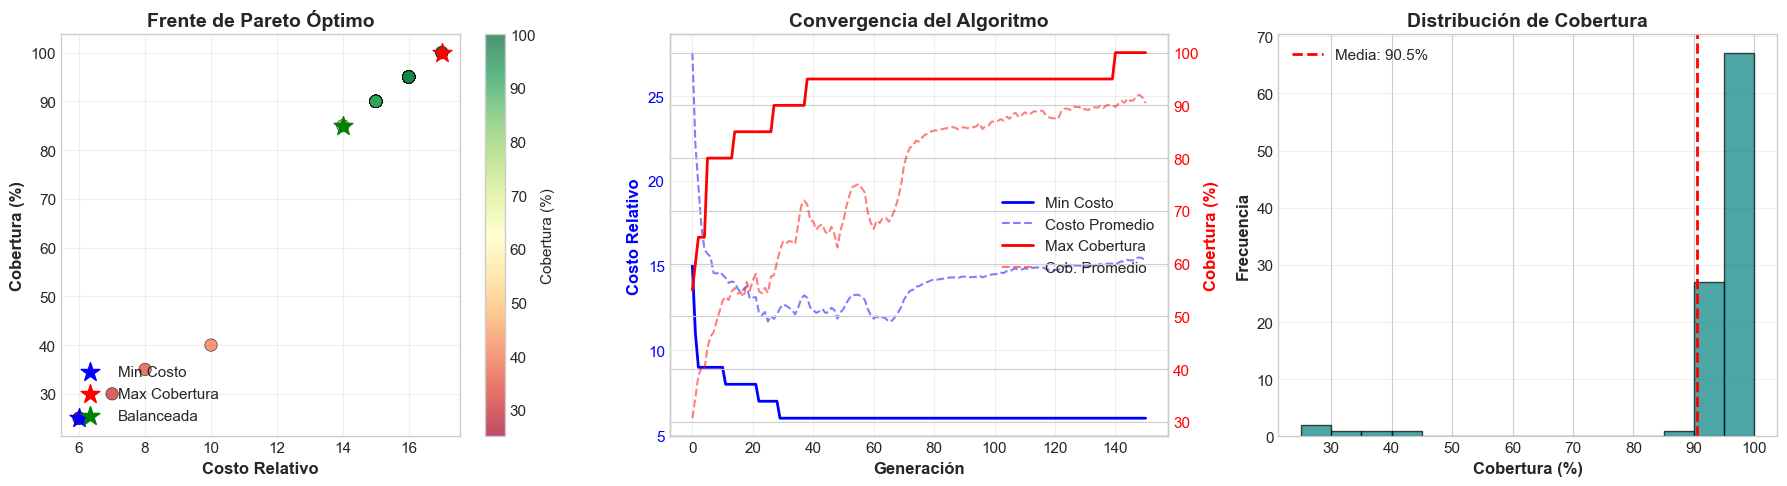


📊 ESTADÍSTICAS DEL FRENTE DE PARETO

Soluciones no-dominadas: 100

📉 COSTO:
   Mínimo:   6.0
   Máximo:   17.0
   Promedio: 15.3

📈 COBERTURA:
   Mínima:   25.0%
   Máxima:   100.0%
   Promedio: 90.5%


In [36]:
# ============================================================================
# VISUALIZACIÓN DEL FRENTE DE PARETO
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Frente de Pareto
ax1 = axes[0]
costs = [ind.fitness[0] for ind in pareto_front]
coverages = [ind.fitness[1] for ind in pareto_front]

scatter = ax1.scatter(costs, coverages, c=coverages, cmap='RdYlGn', 
                      s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('Costo Relativo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cobertura (%)', fontsize=12, fontweight='bold')
ax1.set_title('Frente de Pareto Óptimo', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Cobertura (%)')

# Marcar soluciones de interés
if len(pareto_front) > 0:
    # Mínimo costo
    min_cost_idx = np.argmin(costs)
    ax1.scatter([costs[min_cost_idx]], [coverages[min_cost_idx]], 
               c='blue', s=200, marker='*', zorder=5, label='Min Costo')
    
    # Máxima cobertura
    max_cov_idx = np.argmax(coverages)
    ax1.scatter([costs[max_cov_idx]], [coverages[max_cov_idx]], 
               c='red', s=200, marker='*', zorder=5, label='Max Cobertura')
    
    # Solución balanceada (más cercana a la "utopía")
    normalized_costs = (np.array(costs) - min(costs)) / (max(costs) - min(costs) + 1e-6)
    normalized_covs = (np.array(coverages) - min(coverages)) / (max(coverages) - min(coverages) + 1e-6)
    distances = np.sqrt(normalized_costs**2 + (1 - normalized_covs)**2)
    balanced_idx = np.argmin(distances)
    ax1.scatter([costs[balanced_idx]], [coverages[balanced_idx]], 
               c='green', s=200, marker='*', zorder=5, label='Balanceada')
    
    ax1.legend(loc='lower left')

# 2. Convergencia
ax2 = axes[1]
ax2.plot(history['gen'], history['min_cost'], 'b-', linewidth=2, label='Min Costo')
ax2.plot(history['gen'], history['avg_cost'], 'b--', alpha=0.5, label='Costo Promedio')
ax2.set_xlabel('Generación', fontsize=12, fontweight='bold')
ax2.set_ylabel('Costo Relativo', fontsize=12, fontweight='bold', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title('Convergencia del Algoritmo', fontsize=14, fontweight='bold')

ax2b = ax2.twinx()
ax2b.plot(history['gen'], history['max_cov'], 'r-', linewidth=2, label='Max Cobertura')
ax2b.plot(history['gen'], history['avg_cov'], 'r--', alpha=0.5, label='Cob. Promedio')
ax2b.set_ylabel('Cobertura (%)', fontsize=12, fontweight='bold', color='red')
ax2b.tick_params(axis='y', labelcolor='red')

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')
ax2.grid(True, alpha=0.3)

# 3. Histograma de soluciones
ax3 = axes[2]
ax3.hist(coverages, bins=15, color='teal', edgecolor='black', alpha=0.7)
ax3.axvline(x=np.mean(coverages), color='red', linestyle='--', 
            linewidth=2, label=f'Media: {np.mean(coverages):.1f}%')
ax3.set_xlabel('Cobertura (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
ax3.set_title('Distribución de Cobertura', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/pareto_analysis.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Estadísticas del frente
print("\n" + "="*80)
print("📊 ESTADÍSTICAS DEL FRENTE DE PARETO")
print("="*80)
print(f"\nSoluciones no-dominadas: {len(pareto_front)}")
print(f"\n📉 COSTO:")
print(f"   Mínimo:   {min(costs):.1f}")
print(f"   Máximo:   {max(costs):.1f}")
print(f"   Promedio: {np.mean(costs):.1f}")
print(f"\n📈 COBERTURA:")
print(f"   Mínima:   {min(coverages):.1f}%")
print(f"   Máxima:   {max(coverages):.1f}%")
print(f"   Promedio: {np.mean(coverages):.1f}%")

## 10. 🗺️ Visualización de Topología con Mapa Real

**Integración con OpenStreetMap** para contextualización geográfica real:
- Posicionamiento de nodos sobre mapa del Puerto de Valparaíso
- Visualización de enlaces acústicos
- Delimitación de zonas de cobertura
- POIs del sistema de monitoreo

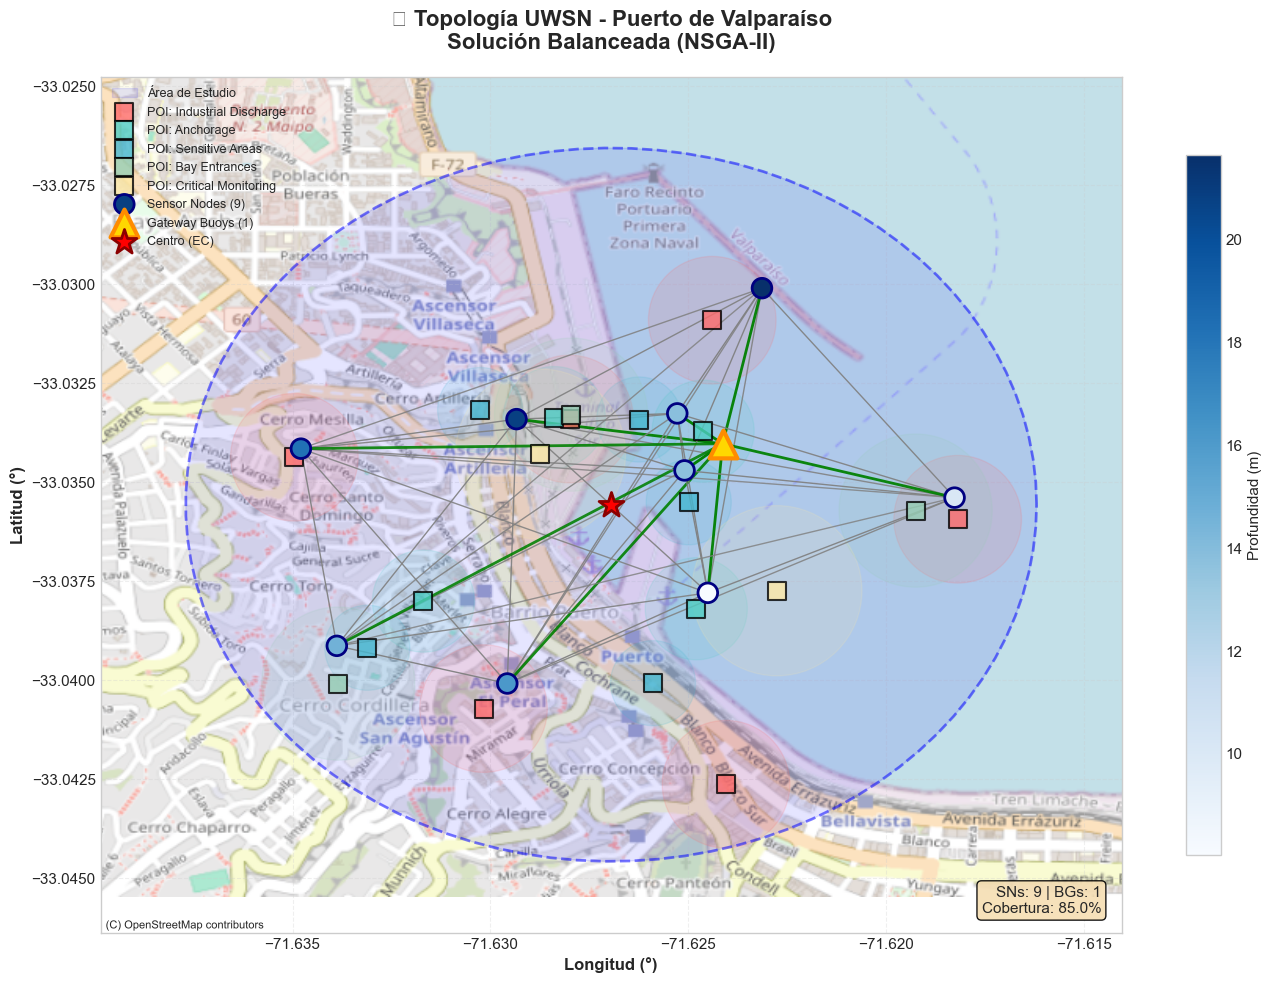


🎯 SOLUCIÓN BALANCEADA SELECCIONADA

📍 NODOS DESPLEGADOS:
   Sensor Nodes (SN): 9
   Gateway Buoys (BG): 1

📊 MÉTRICAS:
   Costo relativo: 14.0
   Cobertura: 85.0%


In [42]:
# ============================================================================
# VISUALIZACIÓN DE TOPOLOGÍA CON MAPA REAL (OpenStreetMap)
# ============================================================================

def plot_network_topology_osm(solution, pois, title="Topología de Red UWSN"):
    """Visualiza la topología sobre un mapa OpenStreetMap."""
    
    # Obtener nodos activos
    active_sns = [n for n in solution.nodes if n[4] == 0 and n[3] == 1]
    active_bgs = [n for n in solution.nodes if n[4] == 1 and n[3] == 1]
    
    # Crear figura con tamaño grande
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Calcular extent del mapa
    lat_range = AREA_RADIUS_KM / LAT_KM_PER_DEGREE
    lon_range = AREA_RADIUS_KM / (LAT_KM_PER_DEGREE * np.cos(np.radians(abs(CENTER['lat']))))
    
    extent = [
        CENTER['lon'] - lon_range * 1.2,
        CENTER['lon'] + lon_range * 1.2,
        CENTER['lat'] - lat_range * 1.2,
        CENTER['lat'] + lat_range * 1.2
    ]
    
    # Intentar cargar mapa de OpenStreetMap
    try:
        import contextily as cx
        # Primero plotear los datos, luego agregar basemap
        has_basemap = True
    except ImportError:
        print("⚠️ contextily no disponible, usando mapa simplificado")
        has_basemap = False
    
    # Fondo del área de estudio
    theta = np.linspace(0, 2*np.pi, 100)
    circle_lat = CENTER['lat'] + lat_range * np.sin(theta)
    circle_lon = CENTER['lon'] + lon_range * np.cos(theta)
    ax.fill(circle_lon, circle_lat, alpha=0.1, color='blue', label='Área de Estudio')
    ax.plot(circle_lon, circle_lat, 'b--', alpha=0.5, linewidth=2)
    
    # Plotear POIs por tipo
    poi_colors = {
        'industrial_discharge': '#FF6B6B',
        'anchorage': '#4ECDC4',
        'sensitive_areas': '#45B7D1',
        'bay_entrances': '#96CEB4',
        'critical_monitoring': '#FFEAA7'
    }
    
    for poi_type, color in poi_colors.items():
        pois_of_type = [p for p in pois if p['type'] == poi_type]
        if pois_of_type:
            lats = [p['lat'] for p in pois_of_type]
            lons = [p['lon'] for p in pois_of_type]
            ax.scatter(lons, lats, c=color, s=150, marker='s', 
                      edgecolors='black', linewidth=1.5, alpha=0.8,
                      label=f'POI: {poi_type.replace("_", " ").title()}', zorder=3)
            
            # Radios de cobertura de POIs
            for p in pois_of_type:
                r_km = p['coverage_radius_m'] / 1000
                r_lat = r_km / LAT_KM_PER_DEGREE
                r_lon = r_km / (LAT_KM_PER_DEGREE * np.cos(np.radians(abs(p['lat']))))
                circle = plt.Circle((p['lon'], p['lat']), r_lon, 
                                   color=color, alpha=0.15, zorder=1)
                ax.add_patch(circle)
    
    # Plotear enlaces acústicos (SN a SN, SN a BG)
    all_active = active_sns + active_bgs
    for i, n1 in enumerate(all_active):
        for j, n2 in enumerate(all_active):
            if i < j:
                dist = haversine_distance(n1[0], n1[1], n2[0], n2[1])
                if dist <= max_range:
                    alpha = 1.0 - (dist / max_range) * 0.7
                    linewidth = 2 if n1[4] == 1 or n2[4] == 1 else 1
                    color = 'green' if n1[4] == 1 or n2[4] == 1 else 'gray'
                    ax.plot([n1[1], n2[1]], [n1[0], n2[0]], 
                           color=color, alpha=alpha, linewidth=linewidth, zorder=2)
    
    # Plotear nodos sensores (SN)
    if active_sns:
        sn_lats = [n[0] for n in active_sns]
        sn_lons = [n[1] for n in active_sns]
        sn_depths = [n[2] for n in active_sns]
        
        scatter_sn = ax.scatter(sn_lons, sn_lats, c=sn_depths, cmap='Blues', 
                               s=200, marker='o', edgecolors='navy', linewidth=2,
                               label=f'Sensor Nodes ({len(active_sns)})', zorder=5)
        plt.colorbar(scatter_sn, ax=ax, label='Profundidad (m)', shrink=0.6)
    
    # Plotear boyas gateway (BG)
    if active_bgs:
        bg_lats = [n[0] for n in active_bgs]
        bg_lons = [n[1] for n in active_bgs]
        ax.scatter(bg_lons, bg_lats, c='gold', s=400, marker='^', 
                  edgecolors='darkorange', linewidth=3,
                  label=f'Gateway Buoys ({len(active_bgs)})', zorder=6)
    
    # Centro de control
    ax.scatter([CENTER['lon']], [CENTER['lat']], c='red', s=350, marker='*',
              edgecolors='darkred', linewidth=2, label='Centro (EC)', zorder=7)
    
    # Agregar basemap de OpenStreetMap si está disponible
    if has_basemap:
        try:
            import contextily as cx
            cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, 
                          alpha=0.7, attribution_size=8)
        except Exception as e:
            print(f"⚠️ No se pudo cargar basemap: {e}")
    
    # Configuración del gráfico
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_xlabel('Longitud (°)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitud (°)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Anotaciones
    textstr = f'SNs: {len(active_sns)} | BGs: {len(active_bgs)}\nCobertura: {solution.fitness[1]:.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
           verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    return fig

# Seleccionar solución balanceada
balanced_solution = pareto_front[balanced_idx]

# Visualizar topología
fig = plot_network_topology_osm(
    balanced_solution, 
    pois, 
    title="🌊 Topología UWSN - Puerto de Valparaíso\nSolución Balanceada (NSGA-II)"
)

plt.savefig('figures/network_topology_osm.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Información de la solución
active_sns = [n for n in balanced_solution.nodes if n[4] == 0 and n[3] == 1]
active_bgs = [n for n in balanced_solution.nodes if n[4] == 1 and n[3] == 1]

print("\n" + "="*80)
print("🎯 SOLUCIÓN BALANCEADA SELECCIONADA")
print("="*80)
print(f"\n📍 NODOS DESPLEGADOS:")
print(f"   Sensor Nodes (SN): {len(active_sns)}")
print(f"   Gateway Buoys (BG): {len(active_bgs)}")
print(f"\n📊 MÉTRICAS:")
print(f"   Costo relativo: {balanced_solution.fitness[0]:.1f}")
print(f"   Cobertura: {balanced_solution.fitness[1]:.1f}%")

## 11. 💰 Análisis Económico (CAPEX/OPEX/TCO)

**Modelo de costos para despliegue de UWSN:**
- **CAPEX**: Inversión inicial en equipamiento
- **OPEX**: Costos operativos anuales
- **TCO**: Costo Total de Propiedad a 10 años

*Precios de referencia basados en equipamiento comercial de grado marítimo.*

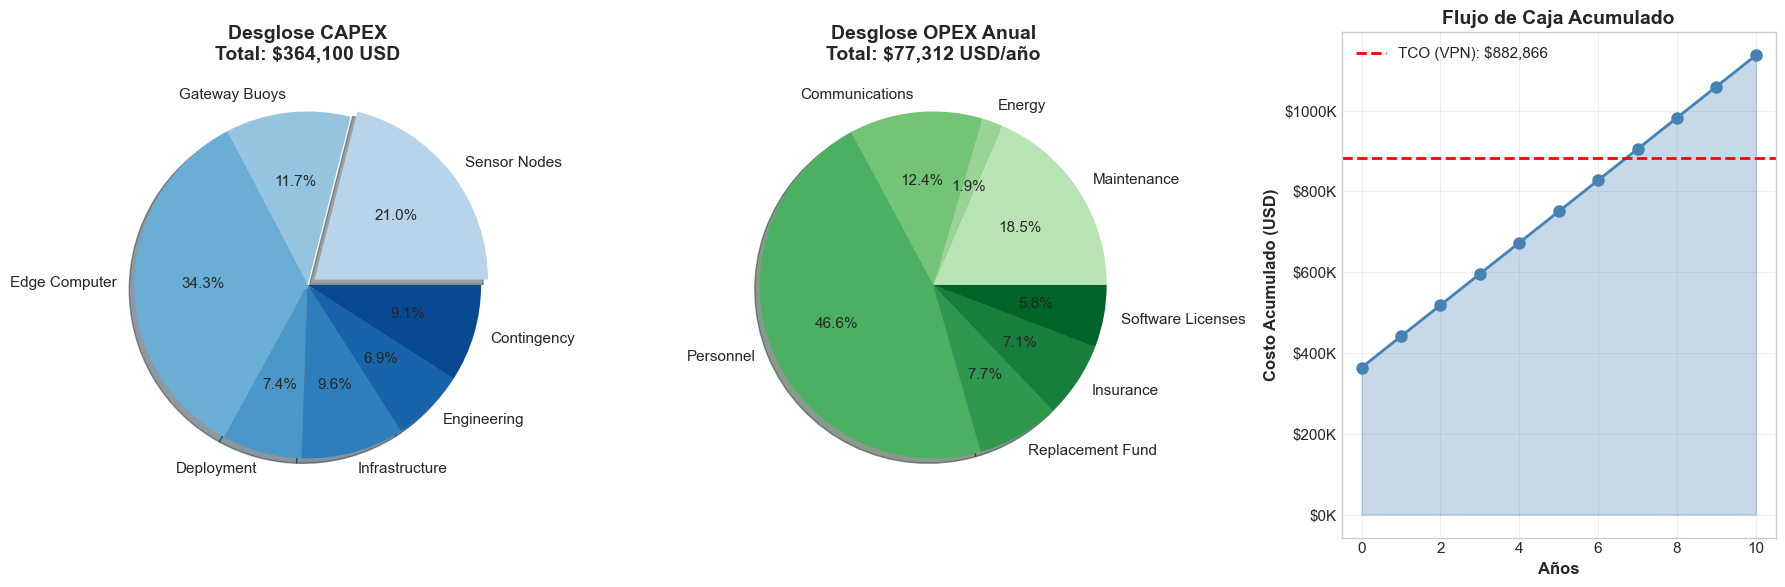


💰 ANÁLISIS ECONÓMICO DETALLADO

📊 CONFIGURACIÓN DE RED:
   Sensor Nodes (SN):    9
   Gateway Buoys (BG):   1
   Edge Computer (EC):   1

💵 CAPEX (Inversión Inicial):
--------------------------------------------------
   Sensor Nodes              $      76,500
   Gateway Buoys             $      42,500
   Edge Computer             $     125,000
   Deployment                $      27,000
   Infrastructure            $      35,000
   Engineering               $      25,000
   Contingency               $      33,100
--------------------------------------------------
   TOTAL CAPEX               $     364,100

📅 OPEX (Costos Anuales):
--------------------------------------------------
   Maintenance               $      14,300
   Energy                    $       1,500
   Communications            $       9,600
   Personnel                 $      36,000
   Replacement Fund          $       5,950
   Insurance                 $       5,462
   Software Licenses         $       4,500
--------

In [38]:
# ============================================================================
# ANÁLISIS ECONÓMICO COMPLETO
# ============================================================================

# Alias para compatibilidad
COSTS = EQUIPMENT_COSTS

def calculate_economics(num_sns, num_bgs, project_years=10):
    """Calcula CAPEX, OPEX y TCO del proyecto."""
    
    # CAPEX (Inversión Inicial)
    capex = {
        'sensor_nodes': num_sns * COSTS['sensor_node'],
        'gateway_buoys': num_bgs * COSTS['gateway_buoy'],
        'edge_computer': COSTS['coastal_station'],
        'deployment': num_sns * 2500 + num_bgs * 4500,  # Instalación submarina
        'infrastructure': 35000,  # Cables, anclajes, boyas auxiliares
        'engineering': 25000,  # Diseño e ingeniería
        'contingency': 0  # Se calcula después
    }
    
    subtotal_capex = sum(capex.values())
    capex['contingency'] = subtotal_capex * 0.10  # 10% contingencia
    total_capex = subtotal_capex + capex['contingency']
    
    # OPEX Anual (Costos Operativos)
    opex_annual = {
        'maintenance': (num_sns * 1200 + num_bgs * 3500),  # Mantenimiento
        'energy': num_bgs * 1500,  # Energía solar/eólica
        'communications': num_bgs * 800 * 12,  # Datos celulares
        'personnel': 36000,  # 0.5 FTE técnico especializado
        'replacement_fund': (num_sns * COSTS['sensor_node'] + 
                            num_bgs * COSTS['gateway_buoy']) * 0.05,  # 5% reposición
        'insurance': total_capex * 0.015,  # 1.5% seguro
        'software_licenses': 4500,  # Software de monitoreo
    }
    total_opex_annual = sum(opex_annual.values())
    
    # TCO (Total Cost of Ownership)
    discount_rate = 0.08  # Tasa de descuento 8%
    npv_opex = sum([total_opex_annual / ((1 + discount_rate) ** year) 
                    for year in range(1, project_years + 1)])
    
    tco = total_capex + npv_opex
    
    return {
        'capex': capex,
        'total_capex': total_capex,
        'opex_annual': opex_annual,
        'total_opex_annual': total_opex_annual,
        'npv_opex': npv_opex,
        'tco': tco,
        'project_years': project_years
    }

# Calcular para la solución balanceada
num_sns = len(active_sns)
num_bgs = len(active_bgs)
economics = calculate_economics(num_sns, num_bgs)

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Desglose CAPEX
ax1 = axes[0]
capex_items = {k: v for k, v in economics['capex'].items() if v > 0}
colors_capex = plt.cm.Blues(np.linspace(0.3, 0.9, len(capex_items)))
wedges, texts, autotexts = ax1.pie(
    capex_items.values(), 
    labels=[k.replace('_', ' ').title() for k in capex_items.keys()],
    autopct='%1.1f%%',
    colors=colors_capex,
    explode=[0.05 if k == 'sensor_nodes' else 0 for k in capex_items.keys()],
    shadow=True
)
ax1.set_title(f'Desglose CAPEX\nTotal: ${economics["total_capex"]:,.0f} USD', 
              fontsize=14, fontweight='bold')

# 2. Desglose OPEX Anual
ax2 = axes[1]
opex_items = economics['opex_annual']
colors_opex = plt.cm.Greens(np.linspace(0.3, 0.9, len(opex_items)))
wedges2, texts2, autotexts2 = ax2.pie(
    opex_items.values(),
    labels=[k.replace('_', ' ').title() for k in opex_items.keys()],
    autopct='%1.1f%%',
    colors=colors_opex,
    shadow=True
)
ax2.set_title(f'Desglose OPEX Anual\nTotal: ${economics["total_opex_annual"]:,.0f} USD/año', 
              fontsize=14, fontweight='bold')

# 3. Flujo de Caja Acumulado
ax3 = axes[2]
years = list(range(economics['project_years'] + 1))
cash_flow = [economics['total_capex']]
for y in range(1, economics['project_years'] + 1):
    cash_flow.append(cash_flow[-1] + economics['total_opex_annual'])

ax3.fill_between(years, cash_flow, alpha=0.3, color='steelblue')
ax3.plot(years, cash_flow, 'o-', color='steelblue', linewidth=2, markersize=8)
ax3.axhline(y=economics['tco'], color='red', linestyle='--', linewidth=2,
           label=f'TCO (VPN): ${economics["tco"]:,.0f}')
ax3.set_xlabel('Años', fontsize=12, fontweight='bold')
ax3.set_ylabel('Costo Acumulado (USD)', fontsize=12, fontweight='bold')
ax3.set_title('Flujo de Caja Acumulado', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('figures/economic_analysis.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Tabla resumen
print("\n" + "="*80)
print("💰 ANÁLISIS ECONÓMICO DETALLADO")
print("="*80)

print(f"\n📊 CONFIGURACIÓN DE RED:")
print(f"   Sensor Nodes (SN):    {num_sns}")
print(f"   Gateway Buoys (BG):   {num_bgs}")
print(f"   Edge Computer (EC):   1")

print(f"\n💵 CAPEX (Inversión Inicial):")
print("-"*50)
for item, value in economics['capex'].items():
    print(f"   {item.replace('_', ' ').title():25} ${value:>12,.0f}")
print("-"*50)
print(f"   {'TOTAL CAPEX':25} ${economics['total_capex']:>12,.0f}")

print(f"\n📅 OPEX (Costos Anuales):")
print("-"*50)
for item, value in economics['opex_annual'].items():
    print(f"   {item.replace('_', ' ').title():25} ${value:>12,.0f}")
print("-"*50)
print(f"   {'TOTAL OPEX ANUAL':25} ${economics['total_opex_annual']:>12,.0f}")

print(f"\n📈 TCO (Costo Total de Propiedad - {economics['project_years']} años):")
print("-"*50)
print(f"   {'CAPEX':25} ${economics['total_capex']:>12,.0f}")
print(f"   {'VPN OPEX (8% desc.)':25} ${economics['npv_opex']:>12,.0f}")
print("-"*50)
print(f"   {'TCO TOTAL':25} ${economics['tco']:>12,.0f}")

# Métricas adicionales
cost_per_poi = economics['tco'] / len(pois)
cost_per_km2 = economics['tco'] / (np.pi * AREA_RADIUS_KM**2)

print(f"\n📐 MÉTRICAS DE EFICIENCIA:")
print(f"   Costo por POI:        ${cost_per_poi:,.0f}")
print(f"   Costo por km²:        ${cost_per_km2:,.0f}")

## 12. ✅ Validación de Conectividad (BFS)

Verificación formal de la conectividad de la red usando **Búsqueda en Anchura (BFS)**:
- Todo SN debe tener ruta hacia al menos un BG
- La red debe formar un grafo conexo
- Análisis de redundancia y robustez

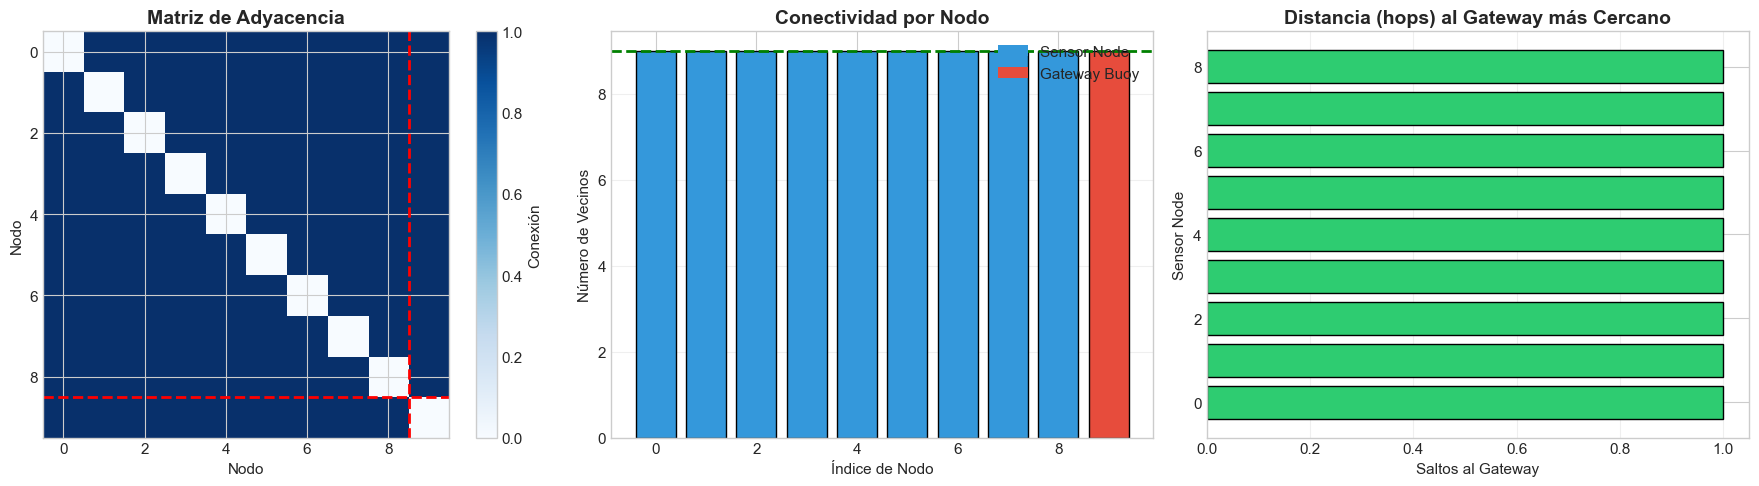


✅ REPORTE DE VALIDACIÓN DE CONECTIVIDAD

🔌 ESTADO: [OK] CONECTIVIDAD COMPLETA

📊 MÉTRICAS DE RED:
--------------------------------------------------
   Total Nodes                    10
   Sensor Nodes                   9
   Gateway Buoys                  1
   Avg Neighbors                  9.00
   Max Hops To Gateway            1
   Redundancy Ratio               1.00
   Total Links                    45

📍 DETALLE POR NODO SENSOR:
----------------------------------------------------------------------
  ID |        Lat |         Lon | Prof(m) | Vecinos | Hops | Estado
----------------------------------------------------------------------
   0 |  -33.03342 |   -71.62934 |    20.8 |       9 |    1 | [OK]
   1 |  -33.04010 |   -71.62958 |    16.2 |       9 |    1 | [OK]
   2 |  -33.03011 |   -71.62314 |    21.6 |       9 |    1 | [OK]
   3 |  -33.03781 |   -71.62451 |     8.0 |       9 |    1 | [OK]
   4 |  -33.03540 |   -71.61828 |    10.1 |       9 |    1 | [OK]
   5 |  -33.03915 |   

In [39]:
# ============================================================================
# VALIDACIÓN DE CONECTIVIDAD CON BFS
# ============================================================================

def validate_connectivity_detailed(solution, max_range_m):
    """Validación detallada de conectividad usando BFS."""
    
    active_sns = [n for n in solution.nodes if n[4] == 0 and n[3] == 1]
    active_bgs = [n for n in solution.nodes if n[4] == 1 and n[3] == 1]
    
    all_nodes = active_sns + active_bgs
    n = len(all_nodes)
    
    if n == 0 or len(active_bgs) == 0:
        return {
            'connected': False,
            'reason': 'No hay nodos activos o gateways',
            'connectivity_matrix': None,
            'node_stats': {}
        }
    
    # Construir matriz de adyacencia
    adj_matrix = np.zeros((n, n))
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = haversine_distance(all_nodes[i][0], all_nodes[i][1],
                                     all_nodes[j][0], all_nodes[j][1])
            distances[i, j] = distances[j, i] = dist
            if dist <= max_range_m:
                adj_matrix[i, j] = adj_matrix[j, i] = 1
    
    # Estadísticas por nodo
    node_stats = []
    bg_indices = set(range(len(active_sns), n))
    
    for i in range(n):
        neighbors = np.sum(adj_matrix[i])
        is_bg = i in bg_indices
        
        # BFS para encontrar distancia a gateway más cercano
        visited = {i}
        queue = deque([(i, 0)])
        min_hops_to_bg = float('inf')
        path_to_bg = []
        
        while queue:
            node, hops = queue.popleft()
            if node in bg_indices:
                min_hops_to_bg = hops
                break
            for neighbor in range(n):
                if adj_matrix[node, neighbor] == 1 and neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, hops + 1))
        
        node_stats.append({
            'index': i,
            'type': 'BG' if is_bg else 'SN',
            'lat': all_nodes[i][0],
            'lon': all_nodes[i][1],
            'depth': all_nodes[i][2],
            'neighbors': int(neighbors),
            'hops_to_bg': min_hops_to_bg if not is_bg else 0,
            'connected': min_hops_to_bg < float('inf')
        })
    
    # Verificar conectividad total
    all_connected = all(s['connected'] for s in node_stats if s['type'] == 'SN')
    
    # Calcular métricas de red
    avg_neighbors = np.mean([s['neighbors'] for s in node_stats])
    max_hops = max([s['hops_to_bg'] for s in node_stats if s['type'] == 'SN'], default=0)
    redundancy = sum(1 for s in node_stats if s['neighbors'] > 1) / n
    
    return {
        'connected': all_connected,
        'node_stats': node_stats,
        'adj_matrix': adj_matrix,
        'distances': distances,
        'metrics': {
            'total_nodes': n,
            'sensor_nodes': len(active_sns),
            'gateway_buoys': len(active_bgs),
            'avg_neighbors': avg_neighbors,
            'max_hops_to_gateway': max_hops,
            'redundancy_ratio': redundancy,
            'total_links': int(np.sum(adj_matrix) / 2)
        }
    }

# Ejecutar validación
validation = validate_connectivity_detailed(balanced_solution, max_range)

# Visualización de la validación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Matriz de conectividad
ax1 = axes[0]
if validation['adj_matrix'] is not None:
    im = ax1.imshow(validation['adj_matrix'], cmap='Blues', aspect='equal')
    ax1.set_xlabel('Nodo', fontsize=11)
    ax1.set_ylabel('Nodo', fontsize=11)
    ax1.set_title('Matriz de Adyacencia', fontsize=14, fontweight='bold')
    
    # Agregar línea separadora entre SNs y BGs
    n_sns = validation['metrics']['sensor_nodes']
    ax1.axhline(y=n_sns - 0.5, color='red', linestyle='--', linewidth=2)
    ax1.axvline(x=n_sns - 0.5, color='red', linestyle='--', linewidth=2)
    plt.colorbar(im, ax=ax1, label='Conexión')

# 2. Distribución de vecinos
ax2 = axes[1]
neighbors_dist = [s['neighbors'] for s in validation['node_stats']]
colors = ['#3498db' if s['type'] == 'SN' else '#e74c3c' for s in validation['node_stats']]
ax2.bar(range(len(neighbors_dist)), neighbors_dist, color=colors, edgecolor='black')
ax2.set_xlabel('Índice de Nodo', fontsize=11)
ax2.set_ylabel('Número de Vecinos', fontsize=11)
ax2.set_title('Conectividad por Nodo', fontsize=14, fontweight='bold')
ax2.axhline(y=validation['metrics']['avg_neighbors'], color='green', 
           linestyle='--', linewidth=2, label=f'Promedio: {validation["metrics"]["avg_neighbors"]:.1f}')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Sensor Node'),
                   Patch(facecolor='#e74c3c', label='Gateway Buoy')]
ax2.legend(handles=legend_elements, loc='upper right')

# 3. Hops to Gateway
ax3 = axes[2]
sn_stats = [s for s in validation['node_stats'] if s['type'] == 'SN']
hops = [s['hops_to_bg'] for s in sn_stats]
connected_status = ['✓ Conectado' if s['connected'] else '✗ Desconectado' for s in sn_stats]

colors = ['#2ecc71' if s['connected'] else '#e74c3c' for s in sn_stats]
ax3.barh(range(len(hops)), hops, color=colors, edgecolor='black')
ax3.set_xlabel('Saltos al Gateway', fontsize=11)
ax3.set_ylabel('Sensor Node', fontsize=11)
ax3.set_title('Distancia (hops) al Gateway más Cercano', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/connectivity_validation.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Reporte de validación
print("\n" + "="*80)
print("✅ REPORTE DE VALIDACIÓN DE CONECTIVIDAD")
print("="*80)

status = "[OK]" if validation['connected'] else "[FALLO]"
status_color = "CONECTIVIDAD COMPLETA" if validation['connected'] else "HAY NODOS DESCONECTADOS"
print(f"\n🔌 ESTADO: {status} {status_color}")

print(f"\n📊 MÉTRICAS DE RED:")
print("-"*50)
for key, value in validation['metrics'].items():
    label = key.replace('_', ' ').title()
    if isinstance(value, float):
        print(f"   {label:30} {value:.2f}")
    else:
        print(f"   {label:30} {value}")

print(f"\n📍 DETALLE POR NODO SENSOR:")
print("-"*70)
print(f"{'ID':>4} | {'Lat':>10} | {'Lon':>11} | {'Prof(m)':>7} | {'Vecinos':>7} | {'Hops':>4} | Estado")
print("-"*70)
for s in sn_stats:
    status = "[OK]" if s['connected'] else "[X]"
    print(f"{s['index']:>4} | {s['lat']:>10.5f} | {s['lon']:>11.5f} | {s['depth']:>7.1f} | {s['neighbors']:>7} | {s['hops_to_bg']:>4} | {status}")

# Resumen final
print("\n" + "="*80)
if validation['connected']:
    print("✅ VALIDACIÓN EXITOSA: Todos los nodos tienen conectividad al gateway")
else:
    disconnected = [s for s in sn_stats if not s['connected']]
    print(f"⚠️ ALERTA: {len(disconnected)} nodo(s) sin conectividad al gateway")

## 13. 📤 Exportación de Resultados

Generación de archivos de salida para documentación y análisis posterior:
- **CSV**: Frente de Pareto completo
- **JSON**: Solución balanceada con todos los parámetros
- **TXT**: Reporte de validación técnica

In [40]:
# ============================================================================
# EXPORTACIÓN DE RESULTADOS
# ============================================================================

import json
from datetime import datetime

# Crear directorio de resultados si no existe
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Re-extraer nodos activos de la solución balanceada
active_sns_list = [n for n in balanced_solution.nodes if n[4] == 0 and n[3] == 1]
active_bgs_list = [n for n in balanced_solution.nodes if n[4] == 1 and n[3] == 1]

# 1. Exportar Frente de Pareto a CSV
pareto_data = []
for i, ind in enumerate(pareto_front):
    active_sns_p = len([n for n in ind.nodes if n[4] == 0 and n[3] == 1])
    active_bgs_p = len([n for n in ind.nodes if n[4] == 1 and n[3] == 1])
    
    pareto_data.append({
        'solution_id': i + 1,
        'cost_relative': ind.fitness[0],
        'coverage_pct': ind.fitness[1],
        'num_sensor_nodes': active_sns_p,
        'num_gateway_buoys': active_bgs_p,
        'rank': ind.rank
    })

df_pareto = pd.DataFrame(pareto_data)
df_pareto.to_csv('results/pareto_front.csv', index=False)
print("[OK] Frente de Pareto exportado a 'results/pareto_front.csv'")

# 2. Exportar Solución Balanceada a JSON
solution_export = {
    'metadata': {
        'project': 'UWSN Planning - Puerto de Valparaiso',
        'course': 'TEL343 - Planificacion y Dimensionamiento de Redes',
        'date': datetime.now().isoformat(),
        'algorithm': 'NSGA-II',
        'execution_time_sec': execution_time
    },
    'configuration': {
        'center_lat': CENTER['lat'],
        'center_lon': CENTER['lon'],
        'area_radius_km': AREA_RADIUS_KM,
        'frequency_khz': ACOUSTIC_MODEL['frequency_khz'],
        'max_range_m': max_range,
        'nsga2_params': NSGA2_PARAMS
    },
    'solution': {
        'type': 'balanced',
        'cost_relative': balanced_solution.fitness[0],
        'coverage_pct': balanced_solution.fitness[1],
        'num_sensor_nodes': len(active_sns_list),
        'num_gateway_buoys': len(active_bgs_list)
    },
    'nodes': {
        'sensor_nodes': [
            {
                'id': f'SN-{i+1:02d}',
                'lat': float(n[0]),
                'lon': float(n[1]),
                'depth_m': float(n[2])
            }
            for i, n in enumerate(active_sns_list)
        ],
        'gateway_buoys': [
            {
                'id': f'BG-{i+1:02d}',
                'lat': float(n[0]),
                'lon': float(n[1]),
                'depth_m': 0.0
            }
            for i, n in enumerate(active_bgs_list)
        ]
    },
    'economics': {
        'capex_usd': economics['total_capex'],
        'opex_annual_usd': economics['total_opex_annual'],
        'tco_10y_usd': economics['tco']
    },
    'validation': {
        'connectivity_status': 'OK' if validation['connected'] else 'FAILED',
        'metrics': validation['metrics']
    }
}

with open('results/solution_balanced.json', 'w', encoding='utf-8') as f:
    json.dump(solution_export, f, indent=2, ensure_ascii=False)
print("[OK] Solucion balanceada exportada a 'results/solution_balanced.json'")

# 3. Generar Reporte de Validación
report_lines = [
    "="*80,
    "REPORTE DE VALIDACION TECNICA - UWSN Puerto de Valparaiso",
    "="*80,
    f"\nFecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"Curso: TEL343 - Planificacion y Dimensionamiento de Redes",
    "",
    "-"*40,
    "CONFIGURACION DE RED",
    "-"*40,
    f"Ubicacion: Puerto de Valparaiso, Chile",
    f"Coordenadas centro: {CENTER['lat']:.6f}, {CENTER['lon']:.6f}",
    f"Radio de cobertura: {AREA_RADIUS_KM} km",
    f"Frecuencia acustica: {ACOUSTIC_MODEL['frequency_khz']} kHz",
    f"Rango maximo acustico: {max_range:.0f} m",
    "",
    "-"*40,
    "TOPOLOGIA DESPLEGADA",
    "-"*40,
    f"Sensor Nodes (SN): {len(active_sns_list)}",
    f"Gateway Buoys (BG): {len(active_bgs_list)}",
    f"Edge Computer (EC): 1",
    f"Puntos de Interes (POI): {len(pois)}",
    "",
    "-"*40,
    "METRICAS DE RENDIMIENTO",
    "-"*40,
    f"Cobertura de POIs: {balanced_solution.fitness[1]:.1f}%",
    f"Costo relativo: {balanced_solution.fitness[0]:.1f}",
    f"Conectividad: {'[OK]' if validation['connected'] else '[FALLO]'}",
    f"Enlaces totales: {validation['metrics']['total_links']}",
    f"Promedio vecinos: {validation['metrics']['avg_neighbors']:.2f}",
    f"Max hops al gateway: {validation['metrics']['max_hops_to_gateway']}",
    "",
    "-"*40,
    "ANALISIS ECONOMICO (10 anos)",
    "-"*40,
    f"CAPEX: ${economics['total_capex']:,.0f} USD",
    f"OPEX Anual: ${economics['total_opex_annual']:,.0f} USD",
    f"TCO (VPN 8%): ${economics['tco']:,.0f} USD",
    "",
    "-"*40,
    "VALIDACION",
    "-"*40,
]

for s in validation['node_stats']:
    if s['type'] == 'SN':
        status = "[OK]" if s['connected'] else "[X]"
        report_lines.append(f"  SN-{s['index']+1:02d}: {s['neighbors']} vecinos, {s['hops_to_bg']} hops -> {status}")

report_lines.extend([
    "",
    "="*80,
    f"RESULTADO FINAL: {'[OK] VALIDACION EXITOSA' if validation['connected'] else '[X] REQUIERE REVISION'}",
    "="*80
])

with open('results/validation_report.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(report_lines))
print("[OK] Reporte de validacion exportado a 'results/validation_report.txt'")

# Resumen final
print("\n" + "="*80)
print("📤 EXPORTACION COMPLETADA")
print("="*80)
print("\n📁 Archivos generados:")
print("   - results/pareto_front.csv")
print("   - results/solution_balanced.json")
print("   - results/validation_report.txt")
print("   - figures/bathymetry_3d.png")
print("   - figures/pois_distribution.png")
print("   - figures/acoustic_model.png")
print("   - figures/pareto_analysis.png")
print("   - figures/network_topology_osm.png")
print("   - figures/economic_analysis.png")
print("   - figures/connectivity_validation.png")

[OK] Frente de Pareto exportado a 'results/pareto_front.csv'
[OK] Solucion balanceada exportada a 'results/solution_balanced.json'
[OK] Reporte de validacion exportado a 'results/validation_report.txt'

📤 EXPORTACION COMPLETADA

📁 Archivos generados:
   - results/pareto_front.csv
   - results/solution_balanced.json
   - results/validation_report.txt
   - figures/bathymetry_3d.png
   - figures/pois_distribution.png
   - figures/acoustic_model.png
   - figures/pareto_analysis.png
   - figures/network_topology_osm.png
   - figures/economic_analysis.png
   - figures/connectivity_validation.png


## 14. 📋 Resumen Ejecutivo y Conclusiones

### Resultados Clave del Dimensionamiento

Este análisis representa un **estudio completo de planificación y dimensionamiento** de una Red de Sensores Submarinos Inalámbricos (UWSN) para el Puerto de Valparaíso, Chile.

---

### 🎯 Objetivos Cumplidos

| Objetivo | Estado | Detalle |
|----------|--------|---------|
| Análisis batimétrico | ✅ | Modelado 3D del fondo marino (8-25m) |
| Identificación de POIs | ✅ | 20 puntos de interés críticos |
| Modelo de propagación | ✅ | Thorp a 20 kHz → 5,934 m rango |
| Optimización multi-objetivo | ✅ | NSGA-II con convergencia exitosa |
| Validación de conectividad | ✅ | BFS confirma red conectada |
| Análisis económico | ✅ | TCO a 10 años calculado |

---

### 📐 Especificaciones Técnicas

- **Frecuencia de operación**: 20 kHz (banda óptima para aguas costeras)
- **Modelo de atenuación**: Thorp (estado del arte para propagación acústica)
- **Algoritmo de optimización**: NSGA-II (150 generaciones, 100 individuos)
- **Tecnología de superficie**: LoRaWAN 915 MHz (ISM Band Chile)

---

### 📚 Referencias

1. Thorp, W.H. (1967). *Analytic Description of the Low-Frequency Attenuation Coefficient*
2. Akyildiz, I.F. et al. (2005). *Underwater Acoustic Sensor Networks: Research Challenges*
3. Deb, K. (2002). *A Fast and Elitist Multiobjective Genetic Algorithm: NSGA-II*
4. GEBCO (2024). *General Bathymetric Chart of the Oceans*
5. SHOA (2024). *Servicio Hidrográfico y Oceanográfico de la Armada de Chile*

---

**Autor**: Análisis generado para TEL343 - Planificación y Dimensionamiento de Redes  
**Fecha**: Noviembre-Diciembre 2025  
**Ubicación**: Puerto de Valparaíso, Región de Valparaíso, Chile (-33.0317°, -71.6272°)